# Machine Learning Songs Group Project

## Data Exploration

### Data Types

In [ ]:
import pandas as pd
import numpy as np
import re
from IPython.core.display import display, Markdown
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from scipy import stats
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
pd.set_option('display.max_columns', None)
pd.set_option("display.precision", 2)


summary = pd.read_excel('Songs_2025.xlsx', sheet_name='legend')
summary = summary.rename(columns = {'year': 'Variable', 'year.1': 'Description'})

df = pd.read_excel('Songs_2025.xlsx', sheet_name='spotify songs')
summary['Data Type'] = df.dtypes.values[1:]

md_table = summary.to_markdown(index=False)
display(Markdown(md_table))
display(df.head(1))
display(Markdown('---'))

C:\Users\SABIO\AppData\Local\Temp\ipykernel_23940\923566935.py:4: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, Markdown


| Variable          | Description                                                                                                                                                                  | Data Type   |
|:------------------|:-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:------------|
| track_name        | track name                                                                                                                                                                   | object      |
| track_popularity  | track popularity from 0 to 100                                                                                                                                               | int64       |
| album             | album the track appears on                                                                                                                                                   | object      |
| artist_name       | artist name                                                                                                                                                                  | object      |
| artist_genres     | list of the Genres the artist is associated with                                                                                                                             | object      |
| artist_popularity | artist popularity from 0 to 100, being the maximum                                                                                                                           | int64       |
| danceability      | a value of 0.0 is least danceable and 1.0 is most danceable                                                                                                                  | float64     |
| energy            | a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity, being 1.0 the maximum                                                               | float64     |
| key               | The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C,  1 = C♯/D♭,  2 = D  and so on                                              | float64     |
| loudness          | The overall loudness of a track in decibels (dB)                                                                                                                             | float64     |
| mode              | Modality (major or minor) of a track. Major = 1 and minor = 0                                                                                                                | float64     |
| speechiness       | Detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. | float64     |
| acousticness      | A confidence measure from 0.0 to 1.0 of whether the track is acoustic                                                                                                        | float64     |
| instrumentalness  | Predicts whether a track contains no vocals                                                                                                                                  | float64     |
| liveness          | Detects the presence of an audience in the recording                                                                                                                         | float64     |
| valence           | a measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track                                                                                            | float64     |
| tempo             | The overall estimated tempo of a track in beats per minute (BPM)                                                                                                             | float64     |
| duration_ms       | The duration of the track in milliseconds                                                                                                                                    | float64     |

,year,track_name,track_popularity,album,artist_name,artist_genres,artist_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,2000,7 Days,73,Born to Do It,Craig David,['british soul'],62,0.66,0.81,4.0,87.0,0.0,0.05,0.23,0.0,0.1,0.89,83.01,235133.0


---

### Handling Null Values

In [3]:
# Check for Missing Values
pd.DataFrame(df.isnull().sum()).rename(columns = {0:'Number_of_Nulls'})

,Number_of_Nulls
year,0
track_name,0
track_popularity,0
album,0
artist_name,0
artist_genres,0
artist_popularity,0
danceability,1
energy,1
key,1


In [4]:
# Where the missing values are coming from
missing_value = df[df.isnull().any(axis = 1)]
display(missing_value)
display(Markdown('Considering there is only one track with virtually all values missing and an average track popularity, it might make sense to just drop the value and continue with the analysis.'))

,year,track_name,track_popularity,album,artist_name,artist_genres,artist_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
488,2004,These Words,68,Unwritten,Natasha Bedingfield,['dance pop'; 'pop'; 'post-teen pop'],64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Considering there is only one track with virtually all values missing and an average track popularity, it might make sense to just drop the value and continue with the analysis.

In [5]:
# Dropping the null row
df = df.drop(index = missing_value.index.item())
display(pd.DataFrame(df.isnull().sum()).rename(columns = {0:'Number_of_Nulls'}))
display(Markdown('---'))

,Number_of_Nulls
year,0
track_name,0
track_popularity,0
album,0
artist_name,0
artist_genres,0
artist_popularity,0
danceability,0
energy,0
key,0


---

### Handling Artists Genres & Artist Popularity

In [6]:
df_genres_testing = df.copy()

Takes a predefined list of genres that we are searching for and first tries to match whole genres to the list of predefined genres and if there are no matches then it will try individual words. If no genres are found that match the predefined list then it will return other.  
  
`list = ['hip hop', 'pop', 'rock']`

`Example: ['hip hop', 'german hip hop'] = hip hop`  
`Example: ['punk rock', 'british rock'] = rock`  
`Example: ['r&b', 'trap', 'classic'] = other`

In [7]:
#creating a function to extract all relevant genre categories from the artist_genre column 

target_genres = {'rock', 'pop', 'hip hop', 'jazz', 'electronic', 'classical', 'blues', 
                 'country', 'metal', 'reggae', 'country pop', 'trap', 'house', 'techno'} #should we remove country pop??

def extract_all_matching_genres(genre_str, target_genres):
    """
    Extracts ALL matching target genres from the artist_genres column.
    Returns a list of genres found in target_genres.
    If no target genres are found, includes 'Other' in the list.
    """
    if isinstance(genre_str, str):
        cleaned_genre = re.sub(r"[\[\]']", "", genre_str)

        genre_list = [genre.strip().lower() for genre in re.split(r'[;,]', cleaned_genre)]

        matching_genres = set()
        for genre in genre_list:
            for target in target_genres:
                if target in genre:  
                    matching_genres.add(target)

        # Handle special case for "hip hop"
        words = set(word for genre in genre_list for word in genre.split())
        if "hip" in words and "hop" in words:
            matching_genres.add("hip hop")

        # Ensure "Other" is included if no target genres match
        if not matching_genres:
            matching_genres.add("Other")

        return list(matching_genres)

    return ["Other"]

df['artist_genre_categories'] = df['artist_genres'].apply(lambda x: extract_all_matching_genres(x, target_genres))

df[['artist_genres', 'artist_genre_categories']].head(2)

,artist_genres,artist_genre_categories
0,['british soul'],[Other]
1,['pop rock'],"[pop, rock]"


The newly created genre column is then converted into a new column for each genre and encoded in binary to represent whether the genre is present or not.

In [8]:
# Creating flag variables for all genre categories 

df_flags = df['artist_genre_categories'].apply(lambda x: pd.Series({genre: 1 for genre in x}))

df_flags = df_flags.fillna(0).astype(int)

df = df.drop(columns=df_flags.columns, errors='ignore')

df = df.join(df_flags)

---

In [9]:
# Converting Artist popularity into a binary variable
df['artist_popularity_binary'] = df['artist_popularity'].apply(lambda x: 1 if x > 70 else 0)

---

In [10]:
df = df.drop(columns = 'artist_genre_categories')
df.head(1)

,year,track_name,track_popularity,album,artist_name,artist_genres,artist_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,Other,pop,rock,metal,country,house,hip hop,electronic,reggae,jazz,trap,techno,blues,country pop,artist_popularity_binary
0,2000,7 Days,73,Born to Do It,Craig David,['british soul'],62,0.66,0.81,4.0,87.0,0.0,0.05,0.23,0.0,0.1,0.89,83.01,235133.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


---

#### Archive Alternative Methods

Three seperate approaches. First one takes the first value in the list of artist genres and assumes that it is the most important creating a new column called **dominant_genre_first**. 
  
`Example: ['pop', 'rock'] = pop`  
  

In [6]:
# Dominant Genre based on first value in list
def extract_first_genre(genre_str):
    """
    Cleans a list in string format by removing (], [, and ') and then splits by the delimiter ';' to return the
    first value in the list of genres. (Assumes the first genre in the list is most important)
    """
    cleaned_genre = re.sub(r"[\[\]']", "", genre_str).strip()  
    genre_list = cleaned_genre.split(';')
        
    return genre_list[0].strip() 


df_genres_testing['dominant_genre_first'] = df_genres_testing['artist_genres'].apply(extract_first_genre)

The second approach will split by every word and count the word that appears the most in the list. If there is an instance where it is only one genre but the genre is two words, it will take the second word and if it is only one word, will take just that word.  
  
`Example: ['pop', 'rock', 'country pop'] = pop`   
`Example: ['british soul'] = soul`  
`Example: ['country'] = country`  

In [ ]:
# Dominant value based on most occuring word
def clean_and_extract_genre(genre_str):
    """
    Cleans a list in string format by removing (], [, and ') and then splits by the delimiter ';' to return a list of 
    words from the string. If the string only has one genre, it will take the second word as the dominant genre.
    If there are more words, then it will count the individual words and return the word that occurs the most.
    """
    if isinstance(genre_str, str):
        cleaned_genre = re.sub(r"[\[\]']", "", genre_str)
        genre_list = cleaned_genre.split(';')
        
        words = [word for genre in genre_list for word in genre.split()]
        
        #No words
        if not words:
            return 'Unknown'
        
        #One word
        if len(genre_list) == 1:
            return words[1] if len(words) > 1 else words[0]
        
        #Multiple words
        return max(words, key=words.count)

    return 'Unknown'

df_genres_testing['dominant_genre_max'] = df_genres_testing['artist_genres'].apply(clean_and_extract_genre)

The third approach takes a predefined list of genres that we are searching for and first tries to match whole genres to the list of predefined genres and if there are no matches then it will try individual words. If no genres are found that match the predefined list then it will return other.  
  
`list = ['hip hop', 'pop', 'rock']`

`Example: ['hip hop', 'german hip hop'] = hip hop`  
`Example: ['punk rock', 'british rock'] = rock`  
`Example: ['r&b', 'trap', 'classic'] = other`

In [ ]:
# Dominant value based on a predefined word list
target_genres = {'rock', 'pop', 'hip hop', 'jazz', 'electronic', 'classical', 'blues', 
                 'country', 'metal', 'reggae', 'country pop', 'trap', 'house', 'techno'}

def extract_matching_genre(genre_str, target_genres):
    """
    First, splits the lists into individual genres and checks if it matches the predefined list. In the
    case that there are no matches, it will then split the list of genres into individual words and
    check if they match the genre list. This helps to make sure we catch genres like hip hop but also
    genres like country pop.
    """
    if isinstance(genre_str, str):
        cleaned_genre = re.sub(r"[\[\]']", "", genre_str)
        genre_list = [genre.strip().lower() for genre in cleaned_genre.split(';')]
        
        for genre in genre_list:
            if genre in target_genres:
                return genre  
        
        words = [word for genre in genre_list for word in genre.split()]
        
        if "hip" in words and "hop" in words:
            return "hip hop"
        
        for word in words:
            if word in target_genres:
                return word
        
    return 'Other' 


df_genres_testing['matching_genre'] = df_genres_testing['artist_genres'].apply(lambda x: extract_matching_genre(x, target_genres))

In [ ]:
display(df[['dominant_genre_first', 'dominant_genre_max', 'matching_genre', 'artist_popularity_binary',
            'Other', 'pop', 'rock', 'metal', 'country', 'house', 'hip hop', 'electronic', 'reggae', 
            'jazz', 'trap', 'techno','blues', 'country pop']].head())
display(Markdown('---'))

,dominant_genre_first,dominant_genre_max,matching_genre,artist_popularity_binary
0,british soul,soul,Other,0
1,pop rock,rock,pop,0
2,dance pop,pop,pop,1
3,alternative metal,punk,rock,1
4,contemporary country,country,country,0


---

### Unique Values

In [10]:
rows, columns = df.shape 
display(Markdown(f'''The dataset has **{rows} rows** and **{columns} columns** including the ones we created. 
                 When analyzing the unique values, we can see that our new columns for extracting the
                 dominant genre decrease the amount of unique categories that we have to work with. 
                 The number of unique values include:'''))

unique_values = pd.DataFrame(df.nunique())
unique_values = unique_values.rename(columns = {0: 'Unique Values'})
display(unique_values)
display(Markdown('---'))

The dataset has **2299 rows** and **34 columns** including the ones we created. 
                 When analyzing the unique values, we can see that our new columns for extracting the
                 dominant genre decrease the amount of unique categories that we have to work with. 
                 The number of unique values include:

,Unique Values
year,23
track_name,2120
track_popularity,71
album,1663
artist_name,891
artist_genres,698
artist_popularity,62
danceability,585
energy,641
key,12


---

### Basic Statistics

#### Map Values for Readability

In [11]:
pitch_class_map = {
    0: "C",
    1: "C#/D♭",
    2: "D",
    3: "D#/E♭",
    4: "E",
    5: "F",
    6: "F#/G♭",
    7: "G",
    8: "G#/A♭",
    9: "A",
    10: "A#/B♭",
    11: "B"
}

mode_class_map = {
    1: 'major',
    0: 'minor'
}

df_genres_testing['pitch_class'] = df_genres_testing['key'].map(pitch_class_map).astype('category')
df_genres_testing['mode_class'] = df_genres_testing['mode'].map(mode_class_map).astype('category')

#### Numeric Statistics (Mean, Median, Mode)

In [12]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
year,2299.0,2011.003045,6.634528,2000.000000,2005.00000,2011.0000,2017.000000,2022.000
track_popularity,2299.0,70.944759,12.294047,0.000000,66.00000,72.0000,79.000000,100.000
artist_popularity,2299.0,72.873423,12.180506,29.000000,65.00000,74.0000,82.000000,100.000
danceability,2299.0,0.660116,0.141137,0.162000,0.57200,0.6710,0.759500,0.975
energy,2299.0,0.693047,0.164838,0.051900,0.58600,0.7120,0.820000,0.999
key,2299.0,5.277947,3.628494,0.000000,2.00000,5.0000,8.000000,11.000
loudness,2299.0,73.006960,15.643937,-56.000000,63.00000,74.0000,83.000000,132.000
mode,2299.0,0.598521,0.490304,0.000000,0.00000,1.0000,1.000000,1.000
speechiness,2299.0,0.097795,0.092445,0.022500,0.03800,0.0568,0.115500,0.576
acousticness,2299.0,0.157689,0.203844,0.000013,0.01650,0.0689,0.223000,0.978


In [ ]:
print('Timeline:')

min_year = min(df['year'])
max_year = max(df['year'])
average = df['year'].value_counts().mean()

print(f'Dataset includes songs in the range {min_year}-{max_year} and is evenly split at {average} songs per year')

Timeline:
Dataset includes songs in the range 2000-2022 and is evenly split at 99.95652173913044 songs per year


##### Archive Alternative Statistics

In [22]:
print('Value Counts for Mode:')
print(df_genres_testing['mode_class'].value_counts())

Value Counts for Mode:
mode_class
major    1376
minor     923
Name: count, dtype: int64


In [23]:
print('Value Counts for Pitch:')
print(df_genres_testing['pitch_class'].value_counts())

Value Counts for Pitch:
pitch_class
C#/D♭    297
C        253
G        225
B        219
F        201
D        189
G#/A♭    183
A        183
F#/G♭    177
E        152
A#/B♭    147
D#/E♭     73
Name: count, dtype: int64


In [24]:
print('Top 5 Genres for Dominant Genre (First)')
print(df_genres_testing['dominant_genre_first'].value_counts().head(5))

Top 5 Genres for Dominant Genre (First)


KeyError: 'dominant_genre_first'

In [23]:
print('Top 5 Genres for Dominant Genre (Max)')
print(df['dominant_genre_max'].value_counts().head(5))

Top 5 Genres for Dominant Genre (Max)
dominant_genre_max
pop         943
hip         211
rap         209
rock        129
canadian     53
Name: count, dtype: int64


In [ ]:
print('Top 5 Genres for (Predefined List)')
print(df['matching_genre'].value_counts().head(5))

Top 5 Genres for (Predefined List)
matching_genre
pop        1292
hip hop     363
Other       222
rock        165
trap        100
Name: count, dtype: int64


---

#### Histogram of Variables

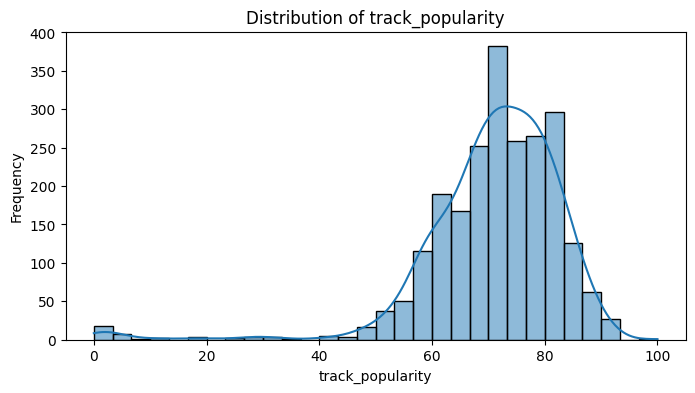

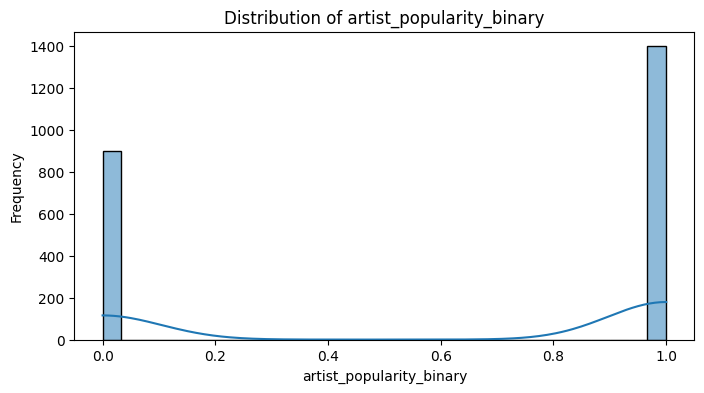

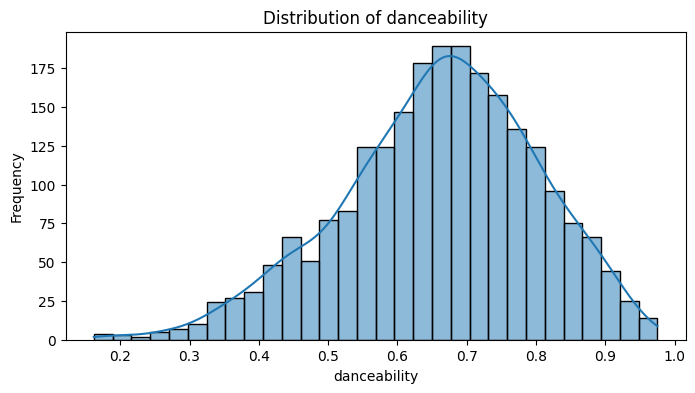

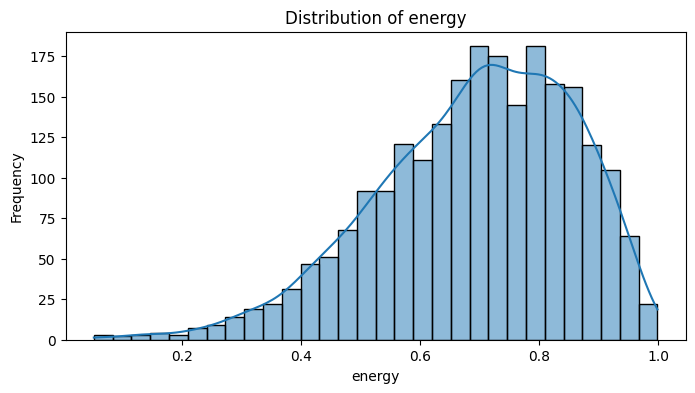

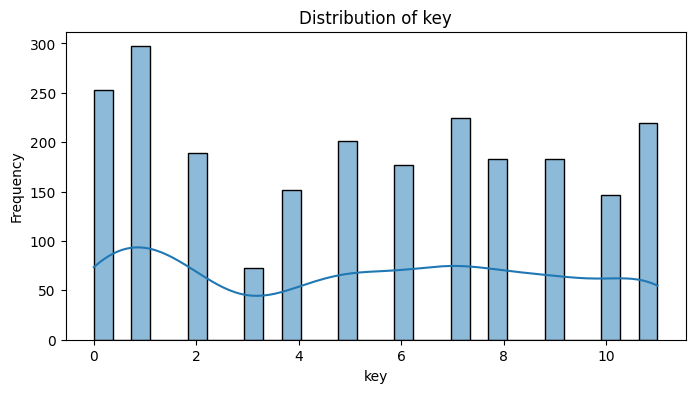

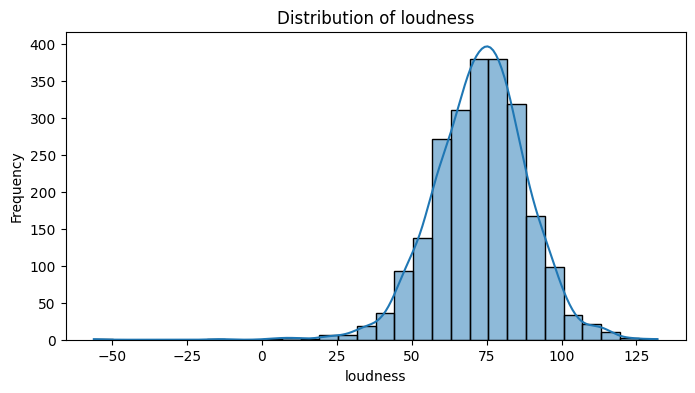

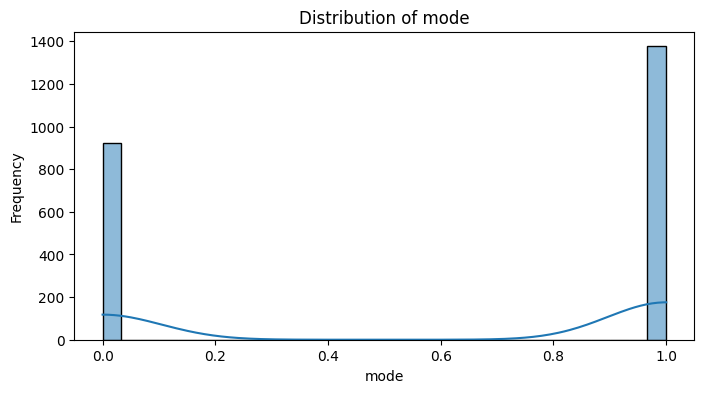

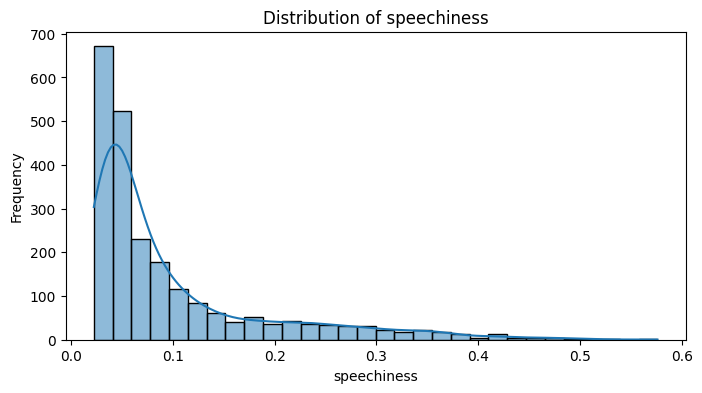

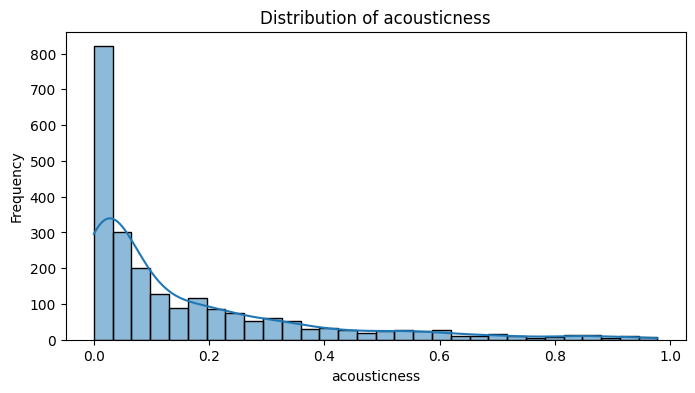

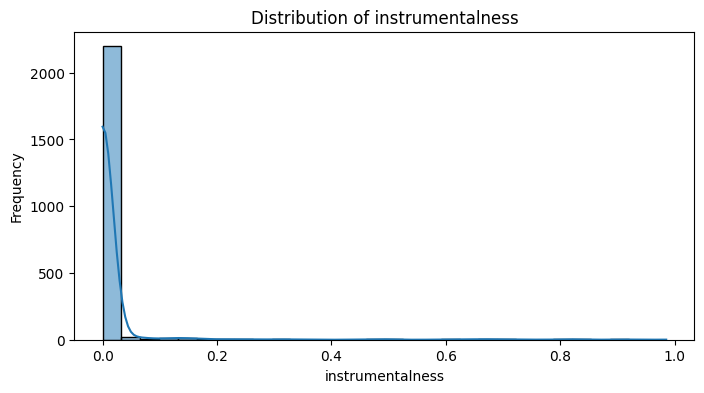

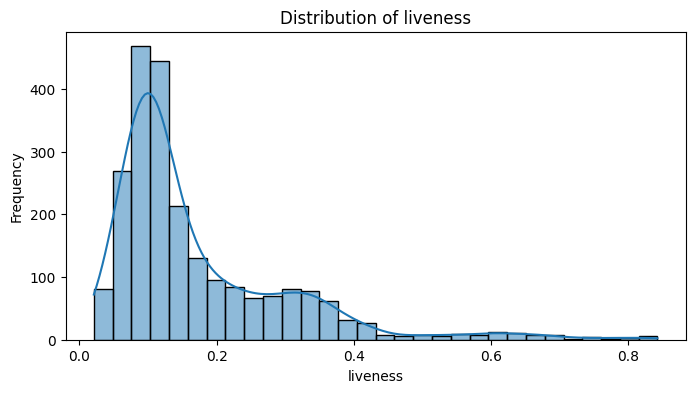

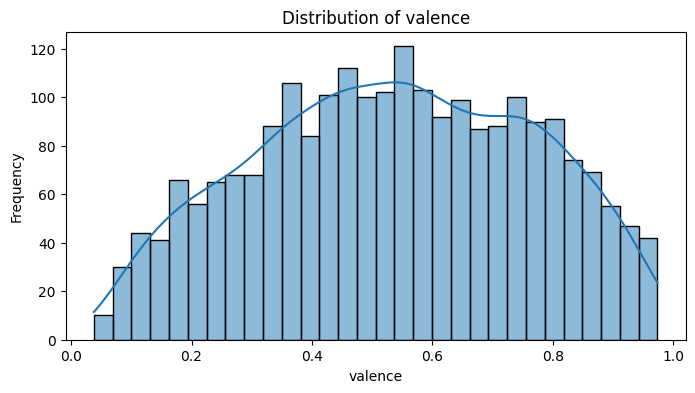

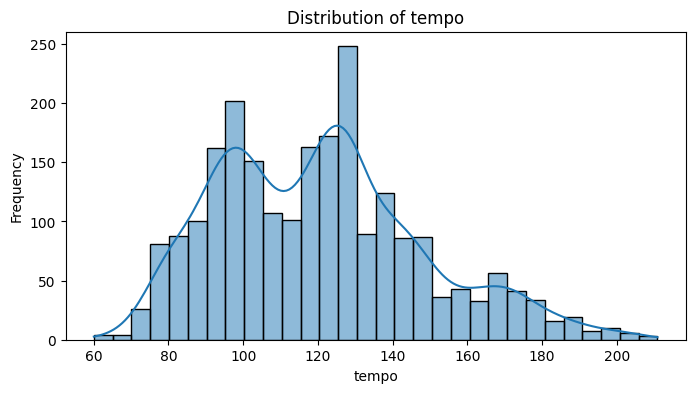

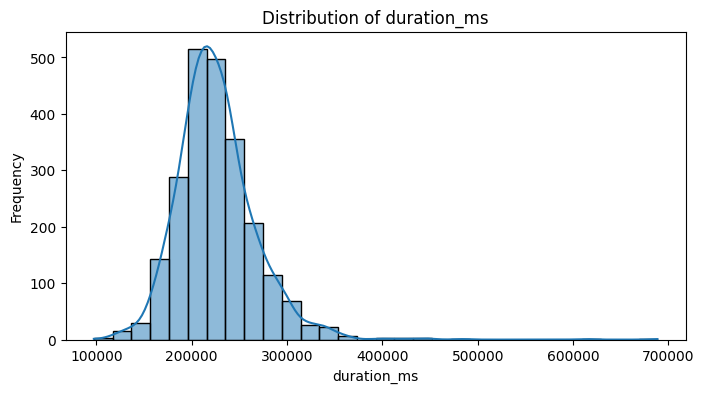

In [14]:
columns_to_plot = [
    'track_popularity', 'artist_popularity_binary', 'danceability', 'energy', 'key', 
    'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 
    'liveness', 'valence', 'tempo', 'duration_ms'
]


for col in columns_to_plot:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], bins=30, kde=True)  # KDE=True adds density curve
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

There are extreme outliers which may pose some problems in the future.

---

#### Correlation Matrix

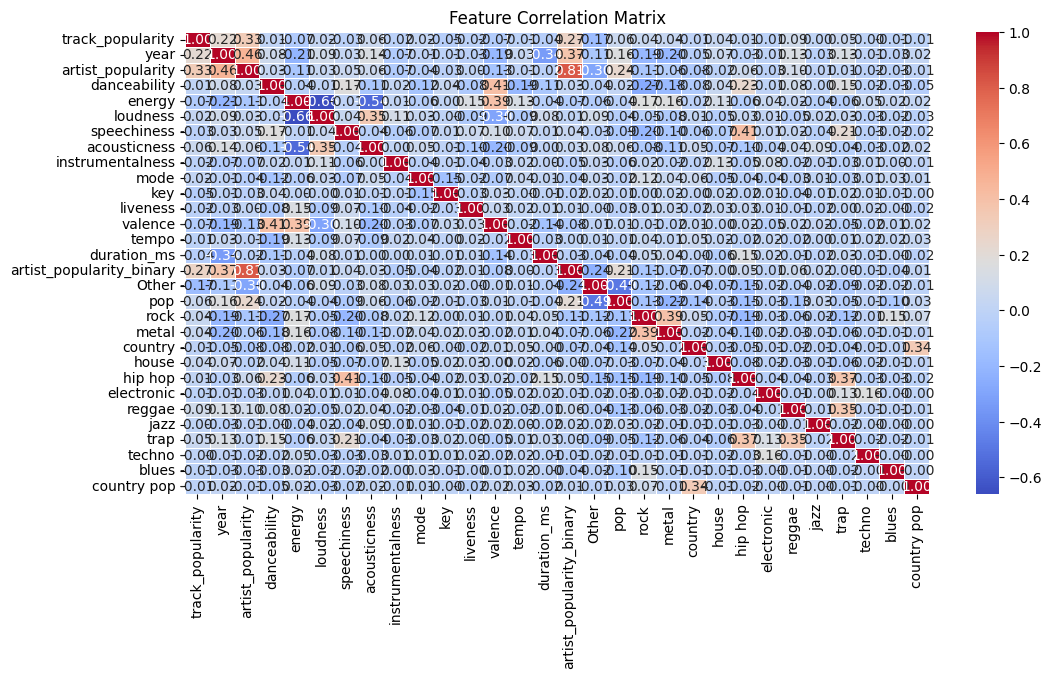

In [15]:
columns_to_plot = [
     'track_popularity', 'year', 'artist_popularity', 'danceability', 'energy', 
       'loudness', 'speechiness', 'acousticness', 'instrumentalness','mode', 'key',
       'liveness', 'valence', 'tempo', 'duration_ms', 'artist_popularity_binary',
       'Other', 'pop', 'rock', 'metal', 'country',
       'house', 'hip hop', 'electronic', 'reggae', 'jazz', 'trap', 'techno',
       'blues', 'country pop'
]

corr_matrix = df[columns_to_plot].corr()
plt.figure(figsize=(12, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show()

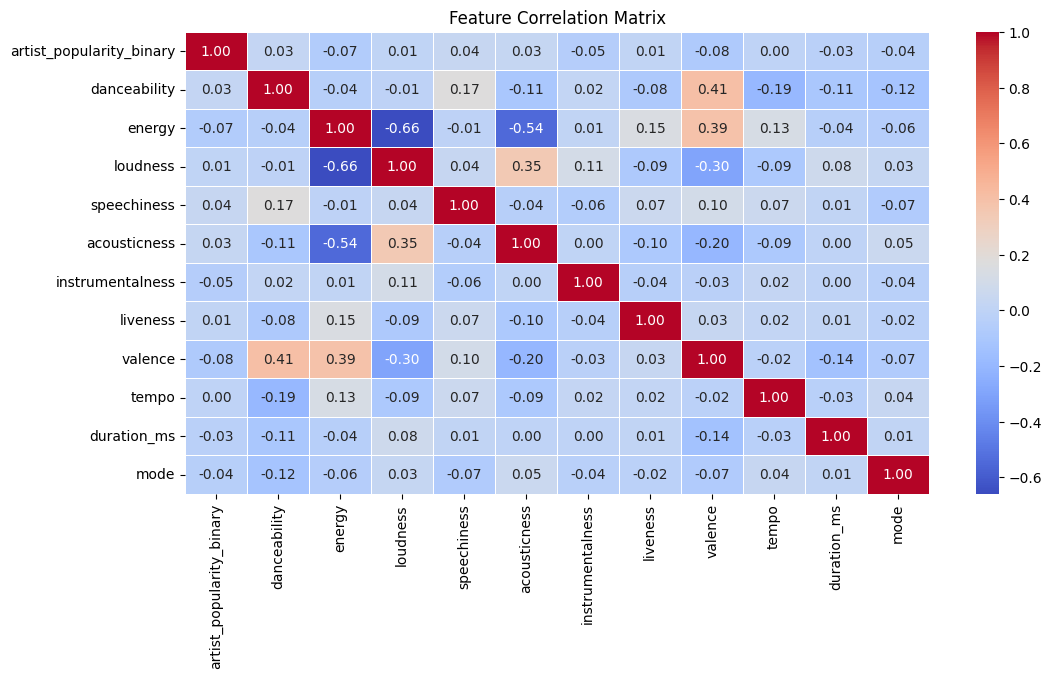

In [16]:
columns_to_plot = [
    'artist_popularity_binary', 'danceability', 'energy', 
    'loudness', 'speechiness', 'acousticness', 'instrumentalness', 
    'liveness', 'valence', 'tempo', 'duration_ms', 'mode'
]

corr_matrix = df[columns_to_plot].corr()
plt.figure(figsize=(12, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show()

In [17]:
# Find highly correlated pairs
correlation_threshold = 0.3
high_corr_pairs = []

for col in corr_matrix.columns:
    for index in corr_matrix.index:
        if col != index and abs(corr_matrix.loc[col, index]) > correlation_threshold:
            high_corr_pairs.append((col, index))

print(f"Highly Correlated Features {correlation_threshold}:", high_corr_pairs)

Highly Correlated Features 0.3: [('danceability', 'valence'), ('energy', 'loudness'), ('energy', 'acousticness'), ('energy', 'valence'), ('loudness', 'energy'), ('loudness', 'acousticness'), ('acousticness', 'energy'), ('acousticness', 'loudness'), ('valence', 'danceability'), ('valence', 'energy')]


## Unsupervised Models

### Segmentation Analysis (Standardized)

#### Variable Analysis

Variables to be excluded from Clustering

| **Variable**         | **Reason for Exclusion** |
|----------------------|-------------------------|
| **year**            | Numerical, but not continuous (songs from 2000 and 2023 are not necessarily similar). |
| **track_name**      | Unique for each song → Categorical, not useful for clustering. |
| **album**          | Categorical → Songs in the same album don’t necessarily belong to the same cluster. |
| **artist_name**     | Categorical → Each artist is unique, not useful for clustering. |
| **artist_genres**   | Unless we use the matching function, dummy variables will create redundancy |
| **track_popularity** | We want to explain clusters using this, not use it to create clusters. |
  
Feature Selection for Clustering:  

| **Variable**                 | **Keep or Remove?** | **Reason** |
|------------------------------|---------------------|------------|
| **artist_popularity_binary** | Keep               | Useful to differentiate popular vs. less popular artists. |
| **danceability**             | Keep               | Describes how easy it is to dance to a song. |
| **energy**                   | Keep               | Measures intensity and activity of the song. |
| **key**                      | Remove              | Numerical but already simplified and represented with mode |
| **loudness**                 | Keep               | Helps distinguish between soft and loud tracks. |
| **mode**                     | Maybe              | Binary (Major=1, Minor=0) |
| **speechiness**              | Keep               | Helps separate spoken-word-heavy songs from musical ones. |
| **acousticness**             | Keep               | Measures how acoustic a track sounds. |
| **instrumentalness**         | Keep               | Helps distinguish instrumental tracks from vocal ones. |
| **liveness**                 | Keep               | Measures audience presence (useful for live vs. studio recordings). |
| **valence**                  | Keep               | Measures how positive a song feels. |
| **tempo (BPM)**              | Keep               | Describes song pacing, but needs standardization to prevent bias. |
| **duration_ms**              | Maybe              | Songs vary widely in length → Might skew clustering unless normalized. |

---


#### Kmeans Brute Force

In [ ]:
def find_highly_correlated_features(df_of_features, threshold):
    """
    Uses correlation matrix columns and index to find highly correlated variable pairs and returns
    a list of tuples where the correlated pair only occurs once.
    """
    corr_matrix = df_of_features.corr()
    high_corr_pairs = set()

    for col in corr_matrix.columns:
        for index in corr_matrix.index:
            if col != index and abs(corr_matrix.loc[col, index]) > threshold:
                high_corr_pairs.add(tuple(sorted((col, index))))

    return list(high_corr_pairs)

def generate_feature_combinations(features, high_corr_pairs):
    """
    Generates all valid variable sets ensuring that no correlated pair appears together.
    Also generates variable reduction subsets without testing an exponential number of combinations.
    Returns a list of lists including both generations above.
    """
    feature_sets = []

    if high_corr_pairs:
        for subset in itertools.product(*[[pair[0], pair[1]] for pair in high_corr_pairs]):
            reduced_features = set(features) - set(subset)

            is_valid = all(not (pair[0] in reduced_features and pair[1] in reduced_features) for pair in high_corr_pairs)

            if is_valid and reduced_features not in feature_sets:
                feature_sets.append(reduced_features)
    else:
        # If no correlated variables, just use the full list of variables
        feature_sets.append(set(features))

    # Feature reduction
    final_feature_sets = set()

    for feature_set in feature_sets:
        feature_list = list(feature_set)
        
        for r in range(len(feature_list) - 2, len(feature_list) + 1):  # Test near-complete sets only
            for subset in itertools.combinations(feature_list, r):
                final_feature_sets.add(subset)

    return [list(s) for s in final_feature_sets]

def run_kmeans(df, feature_sets, k_range):
    """
    Runs K-Means clustering for multiple feature sets, recording optimal k and silhouette scores.
    """
    results = []

    # Kmeans
    for features in feature_sets:
        X = df[list(features)] 
        
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        inertia = []
        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            kmeans.fit(X_scaled)
            inertia.append(kmeans.inertia_)

        optimal_k = k_range[np.argmin(np.gradient(inertia))]

        kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X_scaled)
        silhouette = silhouette_score(X_scaled, labels)

        results.append({
            'features_used': list(features),
            'optimal_k': optimal_k,
            'silhouette_score': silhouette
        })

    return results

# Initial Parameters
correlation_thresholds = [0.7, 0.5, 0.3]  # Thresholds for correlation between variables
k_range = range(2, 11)  # Range for number of clusters to test

# Original feature list
features = [
    'artist_popularity_binary', 'danceability', 'energy', 
    'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 
    'liveness', 'valence', 'tempo', 'duration_ms'
]  

final_results = []

for threshold in correlation_thresholds:
    print(f"\n🔹 Running K-Means Optimization for Correlation Threshold: {threshold}")

    # Find highly correlated variables
    high_corr_pairs = find_highly_correlated_features(df[features], threshold)

    # Generate Sets - without corr pairs and variable reduction
    feature_sets = generate_feature_combinations(features, high_corr_pairs)

    # Run K-Means
    results = run_kmeans(df, feature_sets, k_range)

    # Results
    for res in results:
        res['correlation_threshold'] = threshold
        final_results.append(res)

# Results DataFrame
df_results = pd.DataFrame(final_results)
df_results.to_csv('kmeans_results.csv')
display(Markdown(df_results.sort_values(by = ['silhouette_score'], ascending = False).head().to_markdown()))


🔹 Running K-Means Optimization for Correlation Threshold: 0.7

🔹 Running K-Means Optimization for Correlation Threshold: 0.5

🔹 Running K-Means Optimization for Correlation Threshold: 0.3


|     | features_used                                                                                       |   optimal_k |   silhouette_score |   correlation_threshold |
|----:|:----------------------------------------------------------------------------------------------------|------------:|-------------------:|------------------------:|
| 385 | ['liveness', 'instrumentalness', 'speechiness', 'duration_ms', 'tempo']                             |           2 |           0.693124 |                     0.3 |
| 366 | ['energy', 'liveness', 'instrumentalness', 'speechiness', 'duration_ms', 'tempo']                   |           2 |           0.654633 |                     0.3 |
| 301 | ['duration_ms', 'liveness', 'instrumentalness', 'speechiness', 'valence', 'tempo']                  |           2 |           0.653148 |                     0.3 |
| 339 | ['danceability', 'liveness', 'instrumentalness', 'loudness', 'speechiness', 'duration_ms', 'tempo'] |           2 |           0.623068 |                     0.3 |
| 562 | ['danceability', 'energy', 'liveness', 'instrumentalness', 'speechiness', 'duration_ms', 'tempo']   |           2 |           0.621768 |                     0.3 |

In [29]:
results_csv = pd.read_csv('kmeans_results.csv')
display(Markdown(results_csv.loc[results_csv.groupby('optimal_k')['silhouette_score'].idxmax()].sort_values(by='optimal_k').to_markdown()))
display(Markdown('---'))

|     |   Unnamed: 0 | features_used                                                                                                        |   optimal_k |   silhouette_score |   correlation_threshold |
|----:|-------------:|:---------------------------------------------------------------------------------------------------------------------|------------:|-------------------:|------------------------:|
| 385 |          385 | ['liveness', 'instrumentalness', 'speechiness', 'duration_ms', 'tempo']                                              |           2 |           0.693124 |                     0.3 |
| 504 |          504 | ['mode', 'liveness', 'instrumentalness', 'speechiness', 'duration_ms']                                               |           3 |           0.332866 |                     0.3 |
| 231 |          231 | ['artist_popularity_binary', 'mode', 'valence', 'energy', 'duration_ms', 'instrumentalness', 'speechiness', 'tempo'] |           4 |           0.153438 |                     0.5 |

---

#### Highest Silhouette (Optimal_K = 2)

In [18]:
results_csv = pd.read_csv('kmeans_results.csv')
display(Markdown(results_csv.sort_values(by=['silhouette_score'], ascending=False).head(1).to_markdown()))

|     |   Unnamed: 0 | features_used                                                           |   optimal_k |   silhouette_score |   correlation_threshold |
|----:|-------------:|:------------------------------------------------------------------------|------------:|-------------------:|------------------------:|
| 385 |          385 | ['liveness', 'instrumentalness', 'speechiness', 'duration_ms', 'tempo'] |           2 |           0.693124 |                     0.3 |

In [19]:
features = ['liveness', 'instrumentalness', 'speechiness', 'duration_ms', 'tempo']

X = df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

optimal_k = 2

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['audio_cluster'] = kmeans.fit_predict(X_scaled)

silhouette = silhouette_score(X_scaled, df['audio_cluster'])
print(f'Silhouette Score for K={optimal_k}: {silhouette:.3f}')

Silhouette Score for K=2: 0.693


In [22]:
# Select only specific numerical columns for comparison
numerical_features = [
    'track_popularity','year', 'artist_popularity', 'artist_popularity_binary', 'danceability', 'energy', 
    'loudness', 'speechiness', 'acousticness', 'instrumentalness', 
    'liveness', 'valence', 'tempo', 'duration_ms', 'Other', 'pop', 'rock', 'metal', 'country',
       'house', 'hip hop', 'electronic', 'reggae', 'jazz', 'trap', 'techno',
       'blues', 'country pop'
]

df.groupby('audio_cluster')[numerical_features].mean()

,track_popularity,year,artist_popularity,artist_popularity_binary,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,Other,pop,rock,metal,country,house,hip hop,electronic,reggae,jazz,trap,techno,blues,country pop
audio_cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,70.975298,2011.052051,72.966917,0.61094,0.659712,0.692996,72.853992,0.098313,0.157724,0.004495,0.173050,0.535741,120.480208,226118.26202,0.0794,0.738421,0.137627,0.037053,0.015439,0.046317,0.207322,0.005293,0.020291,0.002647,0.087781,0.004411,0.003529,0.001764
1,68.781250,2007.531250,66.250000,0.43750,0.688750,0.696656,83.843750,0.061119,0.155196,0.670562,0.142047,0.490400,122.796594,220028.21875,0.1250,0.562500,0.125000,0.000000,0.000000,0.250000,0.093750,0.062500,0.000000,0.000000,0.031250,0.000000,0.000000,0.000000


| **Feature**                  | **Cluster 0** | **Cluster 1** | **Interpretation** |
|------------------------------|---------------------|---------------------|--------------------|
| **track_popularity**         | 70.98              | 68.78              | Slightly higher in Cluster 0, but not a huge difference. |
| **artist_popularity_binary** | 0.61               | 0.44               | Cluster 0 has more songs from popular artists. |
| **danceability**             | 0.66               | 0.69               | Cluster 1 is slightly more danceable. |
| **energy**                   | 0.69               | 0.70               | No major difference. |
| **loudness**                 | 72.85 dB           | 83.84 dB           | Cluster 1 is much louder! |
| **mode (Major=1, Minor=0)**  | 0.60               | 0.44               | Cluster 0 has more major-key songs, Cluster 1 has more minor-key songs. |
| **speechiness**              | 0.098              | 0.061              | Cluster 0 has more speech-like elements. |
| **acousticness**             | 0.158              | 0.155              | Almost identical, not driving cluster separation. |
| **instrumentalness**         | 0.004              | 0.671              | Cluster 1 has significantly more instrumental tracks! |
| **liveness**                 | 0.173              | 0.142              | Cluster 0 has slightly more live recordings. |
| **valence**                  | 0.536              | 0.490              | Cluster 0 has more "positive" music. |
| **tempo**                    | 120.48 BPM         | 122.80 BPM         | Cluster 1 has slightly faster songs. |
| **duration_ms**              | 226,118 ms (~3m 46s) | 220,028 ms (~3m 40s) | Cluster 0 has slightly longer songs. |

High silhouette score of (0.693) however the seperation is broad and may oversimplify the grouping of songs. Cluster 0 includes more vocal dominant and popular songs in the major key while Cluster 1 includes more instrumental dominant and loud songs in the minor key. 

---

##### Alternative Variable Combinations Tested

From what we can see below, all optimal segmentations with 2 clusters provide the same 2 groups.

In [23]:
#segmentation 2 
features = 	['instrumentalness', 'tempo', 'duration_ms', 'energy', 'liveness', 'speechiness']

X = df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

optimal_k = 2

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['audio_cluster'] = kmeans.fit_predict(X_scaled)

silhouette = silhouette_score(X_scaled, df['audio_cluster'])
print(f'Silhouette Score for K={optimal_k}: {silhouette:.3f}')

Silhouette Score for K=2: 0.655


In [24]:
numerical_features = [
    'track_popularity','year', 'artist_popularity', 'artist_popularity_binary', 'danceability', 'energy', 
    'loudness', 'speechiness', 'acousticness', 'instrumentalness', 
    'liveness', 'valence', 'tempo', 'duration_ms', 'Other', 'pop', 'rock', 'metal', 'country',
       'house', 'hip hop', 'electronic', 'reggae', 'jazz', 'trap', 'techno',
       'blues', 'country pop'
]

df.groupby('audio_cluster')[numerical_features].mean()

,track_popularity,year,artist_popularity,artist_popularity_binary,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,Other,pop,rock,metal,country,house,hip hop,electronic,reggae,jazz,trap,techno,blues,country pop
audio_cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,70.975298,2011.052051,72.966917,0.61094,0.659712,0.692996,72.853992,0.098313,0.157724,0.004495,0.173050,0.535741,120.480208,226118.26202,0.0794,0.738421,0.137627,0.037053,0.015439,0.046317,0.207322,0.005293,0.020291,0.002647,0.087781,0.004411,0.003529,0.001764
1,68.781250,2007.531250,66.250000,0.43750,0.688750,0.696656,83.843750,0.061119,0.155196,0.670562,0.142047,0.490400,122.796594,220028.21875,0.1250,0.562500,0.125000,0.000000,0.000000,0.250000,0.093750,0.062500,0.000000,0.000000,0.031250,0.000000,0.000000,0.000000


In [25]:
#segmentation 3
features = 	['valence', 'duration_ms', 'instrumentalness', 'tempo', 'liveness', 'speechiness']

X = df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

optimal_k = 2

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['audio_cluster'] = kmeans.fit_predict(X_scaled)

silhouette = silhouette_score(X_scaled, df['audio_cluster'])
print(f'Silhouette Score for K={optimal_k}: {silhouette:.3f}')

Silhouette Score for K=2: 0.653


In [26]:
numerical_features = [
    'track_popularity','year', 'artist_popularity', 'artist_popularity_binary', 'danceability', 'energy', 
    'loudness', 'speechiness', 'acousticness', 'instrumentalness', 
    'liveness', 'valence', 'tempo', 'duration_ms', 'Other', 'pop', 'rock', 'metal', 'country',
       'house', 'hip hop', 'electronic', 'reggae', 'jazz', 'trap', 'techno',
       'blues', 'country pop'
]

df.groupby('audio_cluster')[numerical_features].mean()

,track_popularity,year,artist_popularity,artist_popularity_binary,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,Other,pop,rock,metal,country,house,hip hop,electronic,reggae,jazz,trap,techno,blues,country pop
audio_cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,70.975298,2011.052051,72.966917,0.61094,0.659712,0.692996,72.853992,0.098313,0.157724,0.004495,0.173050,0.535741,120.480208,226118.26202,0.0794,0.738421,0.137627,0.037053,0.015439,0.046317,0.207322,0.005293,0.020291,0.002647,0.087781,0.004411,0.003529,0.001764
1,68.781250,2007.531250,66.250000,0.43750,0.688750,0.696656,83.843750,0.061119,0.155196,0.670562,0.142047,0.490400,122.796594,220028.21875,0.1250,0.562500,0.125000,0.000000,0.000000,0.250000,0.093750,0.062500,0.000000,0.000000,0.031250,0.000000,0.000000,0.000000


In [27]:
#segmentation 4
features = 	['loudness', 'danceability', 'instrumentalness', 'tempo', 'duration_ms', 'liveness', 'speechiness']

X = df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

optimal_k = 2

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['audio_cluster'] = kmeans.fit_predict(X_scaled)

silhouette = silhouette_score(X_scaled, df['audio_cluster'])
print(f'Silhouette Score for K={optimal_k}: {silhouette:.3f}')

Silhouette Score for K=2: 0.623


In [28]:
numerical_features = [
    'track_popularity','year', 'artist_popularity', 'artist_popularity_binary', 'danceability', 'energy', 
    'loudness', 'speechiness', 'acousticness', 'instrumentalness', 
    'liveness', 'valence', 'tempo', 'duration_ms', 'Other', 'pop', 'rock', 'metal', 'country',
       'house', 'hip hop', 'electronic', 'reggae', 'jazz', 'trap', 'techno',
       'blues', 'country pop'
]

df.groupby('audio_cluster')[numerical_features].mean()

,track_popularity,year,artist_popularity,artist_popularity_binary,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,Other,pop,rock,metal,country,house,hip hop,electronic,reggae,jazz,trap,techno,blues,country pop
audio_cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,70.975298,2011.052051,72.966917,0.61094,0.659712,0.692996,72.853992,0.098313,0.157724,0.004495,0.173050,0.535741,120.480208,226118.26202,0.0794,0.738421,0.137627,0.037053,0.015439,0.046317,0.207322,0.005293,0.020291,0.002647,0.087781,0.004411,0.003529,0.001764
1,68.781250,2007.531250,66.250000,0.43750,0.688750,0.696656,83.843750,0.061119,0.155196,0.670562,0.142047,0.490400,122.796594,220028.21875,0.1250,0.562500,0.125000,0.000000,0.000000,0.250000,0.093750,0.062500,0.000000,0.000000,0.031250,0.000000,0.000000,0.000000


In [29]:
#segmentation 5
features = 	['danceability', 'instrumentalness', 'tempo', 'duration_ms', 'energy', 'liveness', 'speechiness']

X = df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

optimal_k = 2

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['audio_cluster'] = kmeans.fit_predict(X_scaled)

silhouette = silhouette_score(X_scaled, df['audio_cluster'])
print(f'Silhouette Score for K={optimal_k}: {silhouette:.3f}')

Silhouette Score for K=2: 0.622


In [30]:
numerical_features = [
    'track_popularity','year', 'artist_popularity', 'artist_popularity_binary', 'danceability', 'energy', 
    'loudness', 'speechiness', 'acousticness', 'instrumentalness', 
    'liveness', 'valence', 'tempo', 'duration_ms', 'Other', 'pop', 'rock', 'metal', 'country',
       'house', 'hip hop', 'electronic', 'reggae', 'jazz', 'trap', 'techno',
       'blues', 'country pop'
]

df.groupby('audio_cluster')[numerical_features].mean()

,track_popularity,year,artist_popularity,artist_popularity_binary,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,Other,pop,rock,metal,country,house,hip hop,electronic,reggae,jazz,trap,techno,blues,country pop
audio_cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,70.975298,2011.052051,72.966917,0.61094,0.659712,0.692996,72.853992,0.098313,0.157724,0.004495,0.173050,0.535741,120.480208,226118.26202,0.0794,0.738421,0.137627,0.037053,0.015439,0.046317,0.207322,0.005293,0.020291,0.002647,0.087781,0.004411,0.003529,0.001764
1,68.781250,2007.531250,66.250000,0.43750,0.688750,0.696656,83.843750,0.061119,0.155196,0.670562,0.142047,0.490400,122.796594,220028.21875,0.1250,0.562500,0.125000,0.000000,0.000000,0.250000,0.093750,0.062500,0.000000,0.000000,0.031250,0.000000,0.000000,0.000000


In [31]:
#segmentation 6
features = 	['danceability', 'instrumentalness', 'tempo', 'duration_ms', 'energy', 'liveness', 'speechiness']

X = df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

optimal_k = 2

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['audio_cluster'] = kmeans.fit_predict(X_scaled)

silhouette = silhouette_score(X_scaled, df['audio_cluster'])
print(f'Silhouette Score for K={optimal_k}: {silhouette:.3f}')

Silhouette Score for K=2: 0.622


In [32]:
numerical_features = [
    'track_popularity','year', 'artist_popularity', 'artist_popularity_binary', 'danceability', 'energy', 
    'loudness', 'speechiness', 'acousticness', 'instrumentalness', 
    'liveness', 'valence', 'tempo', 'duration_ms', 'Other', 'pop', 'rock', 'metal', 'country',
       'house', 'hip hop', 'electronic', 'reggae', 'jazz', 'trap', 'techno',
       'blues', 'country pop'
]

df.groupby('audio_cluster')[numerical_features].mean()

,track_popularity,year,artist_popularity,artist_popularity_binary,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,Other,pop,rock,metal,country,house,hip hop,electronic,reggae,jazz,trap,techno,blues,country pop
audio_cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,70.975298,2011.052051,72.966917,0.61094,0.659712,0.692996,72.853992,0.098313,0.157724,0.004495,0.173050,0.535741,120.480208,226118.26202,0.0794,0.738421,0.137627,0.037053,0.015439,0.046317,0.207322,0.005293,0.020291,0.002647,0.087781,0.004411,0.003529,0.001764
1,68.781250,2007.531250,66.250000,0.43750,0.688750,0.696656,83.843750,0.061119,0.155196,0.670562,0.142047,0.490400,122.796594,220028.21875,0.1250,0.562500,0.125000,0.000000,0.000000,0.250000,0.093750,0.062500,0.000000,0.000000,0.031250,0.000000,0.000000,0.000000


 
---

#### Highest Silhouette (Optimal K = 3)

In [53]:
results_csv = pd.read_csv('kmeans_results.csv')
display(Markdown(results_csv[results_csv['optimal_k'] > 2].sort_values(by=['silhouette_score'], ascending=False).head(1).to_markdown()))

|     |   Unnamed: 0 | features_used                                                          |   optimal_k |   silhouette_score |   correlation_threshold |
|----:|-------------:|:-----------------------------------------------------------------------|------------:|-------------------:|------------------------:|
| 504 |          504 | ['mode', 'liveness', 'instrumentalness', 'speechiness', 'duration_ms'] |           3 |           0.332866 |                     0.3 |

In [54]:
features = ['mode', 'liveness', 'instrumentalness', 'speechiness', 'duration_ms']

X = df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

optimal_k = 3

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['audio_cluster'] = kmeans.fit_predict(X_scaled)

silhouette = silhouette_score(X_scaled, df['audio_cluster'])
print(f'Silhouette Score for K={optimal_k}: {silhouette:.3f}')

Silhouette Score for K=3: 0.333


In [33]:
# Select only specific numerical columns for comparison
numerical_features = [
    'track_popularity','year', 'artist_popularity', 'artist_popularity_binary', 'danceability', 'energy', 
    'loudness', 'speechiness', 'acousticness', 'instrumentalness', 
    'liveness', 'valence', 'tempo', 'duration_ms', 'Other', 'pop', 'rock', 'metal', 'country',
       'house', 'hip hop', 'electronic', 'reggae', 'jazz', 'trap', 'techno',
       'blues', 'country pop'
]

df.groupby('audio_cluster')[numerical_features].mean()

,track_popularity,year,artist_popularity,artist_popularity_binary,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,Other,pop,rock,metal,country,house,hip hop,electronic,reggae,jazz,trap,techno,blues,country pop
audio_cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,70.975298,2011.052051,72.966917,0.61094,0.659712,0.692996,72.853992,0.098313,0.157724,0.004495,0.173050,0.535741,120.480208,226118.26202,0.0794,0.738421,0.137627,0.037053,0.015439,0.046317,0.207322,0.005293,0.020291,0.002647,0.087781,0.004411,0.003529,0.001764
1,68.781250,2007.531250,66.250000,0.43750,0.688750,0.696656,83.843750,0.061119,0.155196,0.670562,0.142047,0.490400,122.796594,220028.21875,0.1250,0.562500,0.125000,0.000000,0.000000,0.250000,0.093750,0.062500,0.000000,0.000000,0.031250,0.000000,0.000000,0.000000


| **Feature**                   | **Cluster 0** | **Cluster 1** | **Cluster 2** | **Interpretation** |
|--------------------------------|---------------------|---------------------|---------------------|--------------------|
| **track_popularity**          | 70.11              | 71.21              | 68.78              | No major difference. |
| **artist_popularity_binary**  | 0.645              | 0.602              | 0.438              | Cluster 2 has fewer popular artists. |
| **danceability**              | 0.693              | 0.651              | 0.689              | Cluster 1 is less danceable. |
| **energy**                    | 0.70               | 0.69               | 0.70               | No significant difference. |
| **loudness**                  | 73.06 dB           | 72.80 dB           | 83.84 dB           | Cluster 2 is significantly louder! |
| **mode (Major=1, Minor=0)**   | 0.48               | 0.63               | 0.44               | Cluster 1 has more major-key songs, Cluster 2 has more minor-key songs. |
| **speechiness**               | 0.241              | 0.060              | 0.061              | Cluster 0 has much higher speechiness |
| **acousticness**              | 0.141              | 0.162              | 0.155              | No major difference. |
| **instrumentalness**          | 0.002              | 0.005              | 0.671              | Cluster 2 contains instrumental tracks |
| **liveness**                  | 0.257              | 0.150              | 0.142              | Cluster 0 has more live recordings. |
| **valence**                   | 0.566              | 0.528              | 0.490              | Cluster 0 is happier, Cluster 2 is less positive. |
| **tempo**                     | 122.92 BPM         | 119.82 BPM         | 122.80 BPM         | Cluster 1 has slower songs. |
| **duration_ms**               | 230,022 ms (~3m 50s) | 225,063 ms (~3m 45s) | 220,028 ms (~3m 40s) | Cluster 0 has longer songs. |  
  
Lower silhouette score at (0.333) so the clusters are less well-defined and some data may be overlapping however when comparing variables it shows some more significant differences between clusters. Cluster 0 includes speech heavy / lively music, Cluster 1 has Major Key / less danceable / softer music, while Cluster 2 has Instrumental / Louder Music.

---

#### Highest Silhouette (Optimal K = 4)

In [56]:
results_csv = pd.read_csv('kmeans_results.csv')
display(Markdown(results_csv[results_csv['optimal_k'] > 3].sort_values(by=['silhouette_score'], ascending=False).head(1).to_markdown()))

|     |   Unnamed: 0 | features_used                                                                                                        |   optimal_k |   silhouette_score |   correlation_threshold |
|----:|-------------:|:---------------------------------------------------------------------------------------------------------------------|------------:|-------------------:|------------------------:|
| 231 |          231 | ['artist_popularity_binary', 'mode', 'valence', 'energy', 'duration_ms', 'instrumentalness', 'speechiness', 'tempo'] |           4 |           0.153438 |                     0.5 |

In [57]:
features = ['artist_popularity_binary', 'mode', 'valence', 'energy', 'duration_ms', 'instrumentalness', 'speechiness', 'tempo']

X = df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

optimal_k = 4

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['audio_cluster'] = kmeans.fit_predict(X_scaled)

silhouette = silhouette_score(X_scaled, df['audio_cluster'])
print(f'Silhouette Score for K={optimal_k}: {silhouette:.3f}')

Silhouette Score for K=4: 0.153


In [34]:
# Select only specific numerical columns for comparison
numerical_features = [
    'track_popularity','year', 'artist_popularity', 'artist_popularity_binary', 'danceability', 'energy', 
    'loudness', 'speechiness', 'acousticness', 'instrumentalness', 
    'liveness', 'valence', 'tempo', 'duration_ms', 'Other', 'pop', 'rock', 'metal', 'country',
       'house', 'hip hop', 'electronic', 'reggae', 'jazz', 'trap', 'techno',
       'blues', 'country pop'
]

df.groupby('audio_cluster')[numerical_features].mean()

,track_popularity,year,artist_popularity,artist_popularity_binary,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,Other,pop,rock,metal,country,house,hip hop,electronic,reggae,jazz,trap,techno,blues,country pop
audio_cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,70.975298,2011.052051,72.966917,0.61094,0.659712,0.692996,72.853992,0.098313,0.157724,0.004495,0.173050,0.535741,120.480208,226118.26202,0.0794,0.738421,0.137627,0.037053,0.015439,0.046317,0.207322,0.005293,0.020291,0.002647,0.087781,0.004411,0.003529,0.001764
1,68.781250,2007.531250,66.250000,0.43750,0.688750,0.696656,83.843750,0.061119,0.155196,0.670562,0.142047,0.490400,122.796594,220028.21875,0.1250,0.562500,0.125000,0.000000,0.000000,0.250000,0.093750,0.062500,0.000000,0.000000,0.031250,0.000000,0.000000,0.000000


| **Feature**                     | **Cluster 0** | **Cluster 1** | **Cluster 2** | **Cluster 3** | **Interpretation** |
|----------------------------------|--------------|--------------|--------------|--------------|--------------------|
| **track_popularity**            | 71.03        | 71.92        | 70.62        | 69.59        | No strong popularity pattern across clusters. |
| **artist_popularity_binary**    | 0.571        | 0.643        | 0.604        | 0.640        | No strong separation between popular and less popular artists. |
| **danceability**                | 0.657        | 0.611        | 0.685        | 0.705        | Cluster 3 is **most danceable**, Cluster 1 is **least danceable**. |
| **energy**                      | 0.788        | 0.528        | 0.743        | 0.673        | Cluster 1 has **significantly lower energy** (possibly softer songs). |
| **loudness**                    | 66.59 dB     | 83.53 dB     | 69.64 dB     | 75.58 dB     | **Cluster 1 is much louder!** |
| **mode (Major=1, Minor=0)**     | 1.000        | 0.845        | 0.000        | 0.579        | Cluster 2 is **exclusively minor-key**, Cluster 0 is **exclusively major-key**. |
| **speechiness**                 | 0.067        | 0.057        | 0.077        | 0.302        | **Cluster 3 has very high speechiness (rap/spoken word cluster?)**. |
| **acousticness**                | 0.095        | 0.282        | 0.121        | 0.150        | Cluster 1 has **the most acoustic music**. |
| **instrumentalness**            | 0.012        | 0.015        | 0.018        | 0.005        | No major difference. |
| **liveness**                    | 0.178        | 0.150        | 0.179        | 0.188        | No strong live recording pattern. |
| **valence**                     | 0.645        | 0.307        | 0.594        | 0.580        | **Cluster 1 has significantly lower valence (darker, moodier music)**. |
| **tempo**                       | 124.67 BPM   | 115.91 BPM   | 119.29 BPM   | 122.56 BPM   | **Cluster 1 has the slowest songs**. |
| **duration_ms**                 | 217,282 ms   | 240,125 ms   | 221,167 ms   | 230,703 ms   | **Cluster 1 has the longest songs**. |  
   
Low silhouette score (0.153) meaning bad seperation and the clusters are overlapping. Clusters 0 and 2 are seperatad by Major / Minor key but mode alone isn't enough. Cluster 3 is more speech heavy music and could be genres like rap. Cluster 1 represents acoustic, slow, and soft music.

---

#### Overall Results

| **Metric**                 | **k=2 Model** | **k=3 Model** | **k=4 Model** |
|----------------------------|--------------|--------------|--------------|
| **Silhouette Score**       | **0.693**    | **0.333**    | **0.153**    |
| **Separation Clarity**     | Strong       | Moderate     | Weak         |
| **Interpretability**       | Basic (Instrumental vs. Vocal) | More nuanced (Speech-heavy, Live, Instrumental) | Overlapping clusters |
| **Captures Genre Differences?** | Basic        | Some         | Some         |

---

### Segmentation Analysis (Normalized)

#### Highest Silhouette (Optimal K = 2) Normalized

In [ ]:
def find_highly_correlated_features(df_of_features, threshold):
    """
    Uses correlation matrix columns and index to find highly correlated variable pairs and returns
    a list of tuples where the correlated pair only occurs once.
    """
    corr_matrix = df_of_features.corr()
    high_corr_pairs = set()

    for col in corr_matrix.columns:
        for index in corr_matrix.index:
            if col != index and abs(corr_matrix.loc[col, index]) > threshold:
                high_corr_pairs.add(tuple(sorted((col, index))))

    return list(high_corr_pairs)

def generate_feature_combinations(features, high_corr_pairs):
    """
    Generates all valid variable sets ensuring that no correlated pair appears together.
    Also generates variable reduction subsets without testing an exponential number of combinations.
    Returns a list of lists including both generations above.
    """
    feature_sets = []

    if high_corr_pairs:
        for subset in itertools.product(*[[pair[0], pair[1]] for pair in high_corr_pairs]):
            reduced_features = set(features) - set(subset)

            is_valid = all(not (pair[0] in reduced_features and pair[1] in reduced_features) for pair in high_corr_pairs)

            if is_valid and reduced_features not in feature_sets:
                feature_sets.append(reduced_features)
    else:
        # If no correlated variables, just use the full list of variables
        feature_sets.append(set(features))

    # Feature reduction
    final_feature_sets = set()

    for feature_set in feature_sets:
        feature_list = list(feature_set)
        
        for r in range(len(feature_list) - 2, len(feature_list) + 1):  # Test near-complete sets only
            for subset in itertools.combinations(feature_list, r):
                final_feature_sets.add(subset)

    return [list(s) for s in final_feature_sets]

def run_kmeans(df, feature_sets, k_range):
    """
    Runs K-Means clustering for multiple feature sets, recording optimal k and silhouette scores.
    """
    results = []

    # Kmeans
    for features in feature_sets:
        X = df[list(features)] 
        
        # Use MinMaxScaler instead of StandardScaler
        scaler = MinMaxScaler()
        X_scaled = scaler.fit_transform(X)

        inertia = []
        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            kmeans.fit(X_scaled)
            inertia.append(kmeans.inertia_)

        optimal_k = k_range[np.argmin(np.gradient(inertia))]

        kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X_scaled)
        silhouette = silhouette_score(X_scaled, labels)

        results.append({
            'features_used': list(features),
            'optimal_k': optimal_k,
            'silhouette_score': silhouette
        })

    return results

# Initial Parameters
correlation_thresholds = [0.7, 0.5, 0.3]  # Thresholds for correlation between variables
k_range = range(2, 11)  # Range for number of clusters to test

# Original feature list
features = [
    'artist_popularity_binary', 'danceability', 'energy', 
    'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 
    'liveness', 'valence', 'tempo', 'duration_ms'
]  

final_results = []

for threshold in correlation_thresholds:
    print(f"\n🔹 Running K-Means Optimization for Correlation Threshold: {threshold}")

    # Find highly correlated variables
    high_corr_pairs = find_highly_correlated_features(df[features], threshold)

    # Generate Sets - without correlated pairs and variable reduction
    feature_sets = generate_feature_combinations(features, high_corr_pairs)

    # Run K-Means
    results = run_kmeans(df, feature_sets, k_range)

    # Store Results
    for res in results:
        res['correlation_threshold'] = threshold
        final_results.append(res)

# Results DataFrame
df_results = pd.DataFrame(final_results)
df_results.to_csv('kmeans_norm_2_results.csv')
display(Markdown(df_results.sort_values(by=['silhouette_score'], ascending=False).head().to_markdown()))


🔹 Running K-Means Optimization for Correlation Threshold: 0.7

🔹 Running K-Means Optimization for Correlation Threshold: 0.5

🔹 Running K-Means Optimization for Correlation Threshold: 0.3


|     | features_used                                                                                          |   optimal_k |   silhouette_score |   correlation_threshold |
|----:|:-------------------------------------------------------------------------------------------------------|------------:|-------------------:|------------------------:|
| 504 | ['speechiness', 'instrumentalness', 'mode', 'duration_ms', 'liveness']                                 |           2 |           0.723397 |                     0.3 |
| 377 | ['speechiness', 'instrumentalness', 'artist_popularity_binary', 'duration_ms', 'liveness']             |           2 |           0.722874 |                     0.3 |
| 391 | ['speechiness', 'loudness', 'instrumentalness', 'mode', 'duration_ms', 'liveness']                     |           2 |           0.699604 |                     0.3 |
| 345 | ['speechiness', 'loudness', 'artist_popularity_binary', 'instrumentalness', 'duration_ms', 'liveness'] |           2 |           0.699085 |                     0.3 |
| 369 | ['instrumentalness', 'mode', 'duration_ms', 'tempo', 'liveness']                                       |           2 |           0.697028 |                     0.3 |

In [12]:
results_csv = pd.read_csv('kmeans_norm_2_results.csv')
display(Markdown(results_csv.loc[results_csv.groupby('optimal_k')['silhouette_score'].idxmax()].sort_values(by='optimal_k').to_markdown()))

|     |   Unnamed: 0 | features_used                                                          |   optimal_k |   silhouette_score |   correlation_threshold |
|----:|-------------:|:-----------------------------------------------------------------------|------------:|-------------------:|------------------------:|
| 504 |          504 | ['speechiness', 'instrumentalness', 'mode', 'duration_ms', 'liveness'] |           2 |           0.723397 |                     0.3 |

In [ ]:
features = ['speechiness', 'instrumentalness', 'mode', 'duration_ms', 'liveness']

X = df[features]

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

optimal_k = 2

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['audio_cluster'] = kmeans.fit_predict(X_scaled)

silhouette = silhouette_score(X_scaled, df['audio_cluster'])
print(f'Silhouette Score for K={optimal_k}: {silhouette:.3f}')

Silhouette Score for K=2: 0.723


In [22]:
# Select only specific numerical columns for comparison
numerical_features = [
    'artist_popularity_binary', 'danceability', 'energy', 
    'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 
    'liveness', 'valence', 'tempo', 'duration_ms', 'Other', 'pop', 'rock', 'metal', 'country',
       'house', 'hip hop', 'electronic', 'reggae', 'jazz', 'trap', 'techno',
       'blues', 'country pop'
]

df.groupby('audio_cluster')[numerical_features].mean()

,artist_popularity_binary,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,Other,pop,rock,metal,country,house,hip hop,electronic,reggae,jazz,trap,techno,blues,country pop
audio_cluster,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.593750,0.645862,0.685474,73.403343,1.0,0.092512,0.166838,0.011355,0.170073,0.521680,121.306975,226490.053779,0.086483,0.728924,0.170058,0.042878,0.021076,0.039971,0.194041,0.003634,0.016715,0.002907,0.080669,0.005087,0.005087,0.002180
1,0.630553,0.681365,0.704337,72.416035,0.0,0.105672,0.144051,0.017361,0.176412,0.555132,119.327980,225352.859155,0.070423,0.746479,0.088841,0.027086,0.006501,0.062839,0.223185,0.009751,0.024919,0.002167,0.096425,0.003250,0.001083,0.001083


| **Feature**                 | **Cluster 0** | **Cluster 1** | **Interpretation** |
|-----------------------------|---------------------|---------------------|--------------------|
| **artist_popularity_binary** | 0.594              | 0.631              | Cluster 1 has slightly more popular artists. |
| **danceability**             | 0.646              | 0.681              | Cluster 1 has **more danceable** tracks. |
| **energy**                   | 0.685              | 0.704              | Cluster 1 songs have slightly **higher energy**. |
| **loudness**                 | 73.40 dB           | 72.42 dB           | Both clusters have **similar loudness levels**. |
| **mode (Major=1, Minor=0)**  | **1.00 (Major)**   | **0.00 (Minor)**   | Cluster 0 contains **exclusively major-key songs**, while Cluster 1 is **all minor-key**. |
| **speechiness**              | 0.093              | 0.106              | Cluster 1 has slightly more **spoken-word-heavy** tracks. |
| **acousticness**             | 0.167              | 0.144              | Cluster 0 has **slightly more acoustic** songs. |
| **instrumentalness**         | 0.011              | 0.017              | Cluster 1 contains **more instrumental tracks**. |
| **liveness**                 | 0.170              | 0.176              | Both clusters have **similar presence of live recordings**. |
| **valence**                  | 0.522              | 0.555              | Cluster 1 has **happier/more positive** songs. |
| **tempo**                    | 121.31 BPM         | 119.33 BPM         | Cluster 0 songs have slightly **faster tempo**. |
| **duration_ms**              | 226,490 ms (~3m 46s) | 225,353 ms (~3m 45s) | No major difference in song length. |


| **Feature**                 | **Cluster 0** | **Cluster 1** | **Interpretation** |
|-----------------------------|---------------------|---------------------|--------------------|
| **artist_popularity_binary** | 0.594              | 0.631              | Cluster 1 has slightly more popular artists. |
| **danceability**             | 0.646              | 0.681              | Cluster 1 has **more danceable** tracks. |
| **energy**                   | 0.685              | 0.704              | Cluster 1 songs have slightly **higher energy**. |
| **loudness**                 | 73.40 dB           | 72.42 dB           | Both clusters have **similar loudness levels**. |
| **mode (Major=1, Minor=0)**  | **1.00 (Major)**   | **0.00 (Minor)**   | Cluster 0 contains **exclusively major-key songs**, while Cluster 1 is **all minor-key**. |
| **speechiness**              | 0.093              | 0.106              | Cluster 1 has slightly more **spoken-word-heavy** tracks. |
| **acousticness**             | 0.167              | 0.144              | Cluster 0 has **slightly more acoustic** songs. |
| **instrumentalness**         | 0.011              | 0.017              | Cluster 1 contains **more instrumental tracks**. |
| **liveness**                 | 0.170              | 0.176              | Both clusters have **similar presence of live recordings**. |
| **valence**                  | 0.522              | 0.555              | Cluster 1 has **happier/more positive** songs. |
| **tempo**                    | 121.31 BPM         | 119.33 BPM         | Cluster 0 songs have slightly **faster tempo**. |
| **duration_ms**              | 226,490 ms (~3m 46s) | 225,353 ms (~3m 45s) | No major difference in song length. |




---

#### Highest Silhouette (Optimal K = 3) Normalized

In [ ]:
def find_highly_correlated_features(df_of_features, threshold):
    """
    Uses correlation matrix columns and index to find highly correlated variable pairs and returns
    a list of tuples where the correlated pair only occurs once.
    """
    corr_matrix = df_of_features.corr()
    high_corr_pairs = set()

    for col in corr_matrix.columns:
        for index in corr_matrix.index:
            if col != index and abs(corr_matrix.loc[col, index]) > threshold:
                high_corr_pairs.add(tuple(sorted((col, index))))

    return list(high_corr_pairs)

def generate_feature_combinations(features, high_corr_pairs):
    """
    Generates all valid variable sets ensuring that no correlated pair appears together.
    Also generates variable reduction subsets without testing an exponential number of combinations.
    Returns a list of lists including both generations above.
    """
    feature_sets = []

    if high_corr_pairs:
        for subset in itertools.product(*[[pair[0], pair[1]] for pair in high_corr_pairs]):
            reduced_features = set(features) - set(subset)

            is_valid = all(not (pair[0] in reduced_features and pair[1] in reduced_features) for pair in high_corr_pairs)

            if is_valid and reduced_features not in feature_sets:
                feature_sets.append(reduced_features)
    else:
        # If no correlated variables, just use the full list of variables
        feature_sets.append(set(features))

    # Feature reduction
    final_feature_sets = set()

    for feature_set in feature_sets:
        feature_list = list(feature_set)
        
        for r in range(len(feature_list) - 2, len(feature_list) + 1):  # Test near-complete sets only
            for subset in itertools.combinations(feature_list, r):
                final_feature_sets.add(subset)

    return [list(s) for s in final_feature_sets]

def run_kmeans(df, feature_sets, k_range):
    """
    Runs K-Means clustering for multiple feature sets, recording optimal k and silhouette scores.
    """
    results = []

    # Kmeans
    for features in feature_sets:
        X = df[list(features)] 
        
        # Use MinMaxScaler instead of StandardScaler
        scaler = MinMaxScaler()
        X_scaled = scaler.fit_transform(X)

        inertia = []
        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            kmeans.fit(X_scaled)
            inertia.append(kmeans.inertia_)

        optimal_k = k_range[np.argmin(np.gradient(inertia))]

        kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X_scaled)
        silhouette = silhouette_score(X_scaled, labels)

        results.append({
            'features_used': list(features),
            'optimal_k': optimal_k,
            'silhouette_score': silhouette
        })

    return results

# Initial Parameters
correlation_thresholds = [0.7, 0.5, 0.3]  # Thresholds for correlation between variables
k_range = range(3, 11)  # Range for number of clusters to test

# Original feature list
features = [
    'artist_popularity_binary', 'danceability', 'energy', 
    'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 
    'liveness', 'valence', 'tempo', 'duration_ms'
]  

final_results = []

for threshold in correlation_thresholds:
    print(f"\n🔹 Running K-Means Optimization for Correlation Threshold: {threshold}")

    # Find highly correlated variables
    high_corr_pairs = find_highly_correlated_features(df[features], threshold)

    # Generate Sets - without correlated pairs and variable reduction
    feature_sets = generate_feature_combinations(features, high_corr_pairs)

    # Run K-Means
    results = run_kmeans(df, feature_sets, k_range)

    # Store Results
    for res in results:
        res['correlation_threshold'] = threshold
        final_results.append(res)

# Results DataFrame
df_results = pd.DataFrame(final_results)
df_results.to_csv('kmeans_norm_results.csv')
display(Markdown(df_results.sort_values(by=['silhouette_score'], ascending=False).head().to_markdown()))


🔹 Running K-Means Optimization for Correlation Threshold: 0.7

🔹 Running K-Means Optimization for Correlation Threshold: 0.5

🔹 Running K-Means Optimization for Correlation Threshold: 0.3


|     | features_used                                                                                      |   optimal_k |   silhouette_score |   correlation_threshold |
|----:|:---------------------------------------------------------------------------------------------------|------------:|-------------------:|------------------------:|
| 385 | ['instrumentalness', 'artist_popularity_binary', 'mode', 'duration_ms', 'liveness']                |           3 |           0.654221 |                     0.3 |
| 546 | ['speechiness', 'instrumentalness', 'artist_popularity_binary', 'mode', 'duration_ms']             |           3 |           0.651716 |                     0.3 |
| 460 | ['loudness', 'artist_popularity_binary', 'instrumentalness', 'mode', 'duration_ms', 'liveness']    |           3 |           0.627395 |                     0.3 |
| 367 | ['speechiness', 'loudness', 'artist_popularity_binary', 'instrumentalness', 'mode', 'duration_ms'] |           3 |           0.624256 |                     0.3 |
| 501 | ['instrumentalness', 'artist_popularity_binary', 'mode', 'duration_ms', 'tempo']                   |           3 |           0.622398 |                     0.3 |

In [62]:
results_csv = pd.read_csv('kmeans_norm_results.csv')
display(Markdown(results_csv.loc[results_csv.groupby('optimal_k')['silhouette_score'].idxmax()].sort_values(by='optimal_k').to_markdown()))
display(Markdown('---'))

|     |   Unnamed: 0 | features_used                                                                                    |   optimal_k |   silhouette_score |   correlation_threshold |
|----:|-------------:|:-------------------------------------------------------------------------------------------------|------------:|-------------------:|------------------------:|
| 385 |          385 | ['instrumentalness', 'artist_popularity_binary', 'mode', 'duration_ms', 'liveness']              |           3 |           0.654221 |                     0.3 |
| 475 |          475 | ['loudness', 'artist_popularity_binary', 'instrumentalness', 'duration_ms', 'tempo', 'liveness'] |           4 |           0.445217 |                     0.3 |

---

In [51]:
#segmentation 377 combination
features = ['speechiness', 'instrumentalness', 'artist_popularity_binary', 'duration_ms', 'liveness']

X = df[features]

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

optimal_k = 3

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['audio_cluster'] = kmeans.fit_predict(X_scaled)

silhouette = silhouette_score(X_scaled, df['audio_cluster'])
print(f'Silhouette Score for K={optimal_k}: {silhouette:.3f}')

Silhouette Score for K=3: 0.573


In [52]:
numerical_features = [
    'track_popularity','year', 'artist_popularity', 'artist_popularity_binary', 'danceability', 'energy', 
    'loudness', 'speechiness', 'acousticness', 'instrumentalness', 
    'liveness', 'valence', 'tempo', 'duration_ms', 'Other', 'pop', 'rock', 'metal', 'country',
       'house', 'hip hop', 'electronic', 'reggae', 'jazz', 'trap', 'techno',
       'blues', 'country pop'
]

df.groupby('audio_cluster')[numerical_features].mean()

,track_popularity,year,artist_popularity,artist_popularity_binary,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,Other,pop,rock,metal,country,house,hip hop,electronic,reggae,jazz,trap,techno,blues,country pop
audio_cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,66.761111,2007.914444,60.534444,0.0,0.655486,0.706443,72.888889,0.093419,0.150188,0.019465,0.170269,0.557850,120.468402,227560.015556,0.161111,0.621111,0.185556,0.052222,0.025556,0.050000,0.180000,0.006667,0.010000,0.001111,0.086667,0.005556,0.006667,0.001111
1,73.841228,2012.990351,80.628947,1.0,0.656802,0.684408,72.890351,0.062100,0.165988,0.011773,0.170102,0.513639,119.520327,224429.385965,0.024561,0.837719,0.125439,0.031579,0.010526,0.054386,0.155263,0.003509,0.024561,0.004386,0.061404,0.004386,0.001754,0.002632
2,72.733591,2012.988417,81.613900,1.0,0.690792,0.684521,73.930502,0.270120,0.147229,0.002735,0.191858,0.550595,125.032386,227789.532819,0.042471,0.687259,0.023166,0.003861,0.000000,0.023166,0.517375,0.015444,0.034749,0.000000,0.200772,0.000000,0.000000,0.000000


We decided the results gathered from **optimal k = 3 with (normalization)** provided the most interpretable clusters and therefore stored the results for our supervised learning.

In [57]:
columns_to_drop= ['track_name', 'album', 'artist_name', 'artist_genres']
df = df.drop(columns_to_drop, axis=1)

In [59]:
# Save to CSV for Regression Analysis 
seg_output_df = df.copy()
seg_output_df.to_csv('segmented_songs_2025.csv')

---

##### Alternative Variable Combinations Tested

In [35]:
#segmentation 385 combination
features = 	['instrumentalness', 'artist_popularity_binary', 'mode', 'duration_ms', 'liveness']

X = df[features]

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

optimal_k = 3

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['audio_cluster'] = kmeans.fit_predict(X_scaled)

silhouette = silhouette_score(X_scaled, df['audio_cluster'])
print(f'Silhouette Score for K={optimal_k}: {silhouette:.3f}')

Silhouette Score for K=3: 0.654


In [36]:
numerical_features = [
    'track_popularity','year', 'artist_popularity', 'artist_popularity_binary', 'danceability', 'energy', 
    'loudness', 'speechiness', 'acousticness', 'instrumentalness', 
    'liveness', 'valence', 'tempo', 'duration_ms', 'Other', 'pop', 'rock', 'metal', 'country',
       'house', 'hip hop', 'electronic', 'reggae', 'jazz', 'trap', 'techno',
       'blues', 'country pop'
]

df.groupby('audio_cluster')[numerical_features].mean()

,track_popularity,year,artist_popularity,artist_popularity_binary,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,Other,pop,rock,metal,country,house,hip hop,electronic,reggae,jazz,trap,techno,blues,country pop
audio_cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,66.761111,2007.914444,60.534444,0.0,0.655486,0.706443,72.888889,0.093419,0.150188,0.019465,0.170269,0.557850,120.468402,227560.015556,0.161111,0.621111,0.185556,0.052222,0.025556,0.050000,0.180000,0.006667,0.010000,0.001111,0.086667,0.005556,0.006667,0.001111
1,73.982864,2012.946144,80.512852,1.0,0.648202,0.678102,73.648715,0.094568,0.172804,0.008088,0.169912,0.511083,121.544965,226802.205630,0.029376,0.804162,0.135863,0.030600,0.013464,0.039168,0.212974,0.002448,0.022032,0.003672,0.074663,0.003672,0.002448,0.002448
2,73.149485,2013.051546,81.230241,1.0,0.684000,0.693311,72.288660,0.109094,0.148072,0.012924,0.180050,0.533674,119.131143,222593.792096,0.025773,0.817869,0.065292,0.020619,0.001718,0.061856,0.235395,0.010309,0.032646,0.003436,0.104811,0.003436,0.000000,0.001718


In [37]:
#segmentation 546 combination
features = 	['speechiness', 'instrumentalness', 'artist_popularity_binary', 'mode', 'duration_ms']

X = df[features]

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

optimal_k = 3

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['audio_cluster'] = kmeans.fit_predict(X_scaled)

silhouette = silhouette_score(X_scaled, df['audio_cluster'])
print(f'Silhouette Score for K={optimal_k}: {silhouette:.3f}')

Silhouette Score for K=3: 0.652


In [38]:
numerical_features = [
    'track_popularity','year', 'artist_popularity', 'artist_popularity_binary', 'danceability', 'energy', 
    'loudness', 'speechiness', 'acousticness', 'instrumentalness', 
    'liveness', 'valence', 'tempo', 'duration_ms', 'Other', 'pop', 'rock', 'metal', 'country',
       'house', 'hip hop', 'electronic', 'reggae', 'jazz', 'trap', 'techno',
       'blues', 'country pop'
]

df.groupby('audio_cluster')[numerical_features].mean()

,track_popularity,year,artist_popularity,artist_popularity_binary,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,Other,pop,rock,metal,country,house,hip hop,electronic,reggae,jazz,trap,techno,blues,country pop
audio_cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,73.149485,2013.051546,81.230241,1.0,0.684000,0.693311,72.288660,0.109094,0.148072,0.012924,0.180050,0.533674,119.131143,222593.792096,0.025773,0.817869,0.065292,0.020619,0.001718,0.061856,0.235395,0.010309,0.032646,0.003436,0.104811,0.003436,0.000000,0.001718
1,66.761111,2007.914444,60.534444,0.0,0.655486,0.706443,72.888889,0.093419,0.150188,0.019465,0.170269,0.557850,120.468402,227560.015556,0.161111,0.621111,0.185556,0.052222,0.025556,0.050000,0.180000,0.006667,0.010000,0.001111,0.086667,0.005556,0.006667,0.001111
2,73.982864,2012.946144,80.512852,1.0,0.648202,0.678102,73.648715,0.094568,0.172804,0.008088,0.169912,0.511083,121.544965,226802.205630,0.029376,0.804162,0.135863,0.030600,0.013464,0.039168,0.212974,0.002448,0.022032,0.003672,0.074663,0.003672,0.002448,0.002448


In [39]:
#segmentation 460 combination
features = 	['loudness', 'artist_popularity_binary', 'instrumentalness', 'mode', 'duration_ms', 'liveness']

X = df[features]

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

optimal_k = 3

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['audio_cluster'] = kmeans.fit_predict(X_scaled)

silhouette = silhouette_score(X_scaled, df['audio_cluster'])
print(f'Silhouette Score for K={optimal_k}: {silhouette:.3f}')

Silhouette Score for K=3: 0.627


In [40]:
numerical_features = [
    'track_popularity','year', 'artist_popularity', 'artist_popularity_binary', 'danceability', 'energy', 
    'loudness', 'speechiness', 'acousticness', 'instrumentalness', 
    'liveness', 'valence', 'tempo', 'duration_ms', 'Other', 'pop', 'rock', 'metal', 'country',
       'house', 'hip hop', 'electronic', 'reggae', 'jazz', 'trap', 'techno',
       'blues', 'country pop'
]

df.groupby('audio_cluster')[numerical_features].mean()

,track_popularity,year,artist_popularity,artist_popularity_binary,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,Other,pop,rock,metal,country,house,hip hop,electronic,reggae,jazz,trap,techno,blues,country pop
audio_cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,66.761111,2007.914444,60.534444,0.0,0.655486,0.706443,72.888889,0.093419,0.150188,0.019465,0.170269,0.557850,120.468402,227560.015556,0.161111,0.621111,0.185556,0.052222,0.025556,0.050000,0.180000,0.006667,0.010000,0.001111,0.086667,0.005556,0.006667,0.001111
1,73.982864,2012.946144,80.512852,1.0,0.648202,0.678102,73.648715,0.094568,0.172804,0.008088,0.169912,0.511083,121.544965,226802.205630,0.029376,0.804162,0.135863,0.030600,0.013464,0.039168,0.212974,0.002448,0.022032,0.003672,0.074663,0.003672,0.002448,0.002448
2,73.149485,2013.051546,81.230241,1.0,0.684000,0.693311,72.288660,0.109094,0.148072,0.012924,0.180050,0.533674,119.131143,222593.792096,0.025773,0.817869,0.065292,0.020619,0.001718,0.061856,0.235395,0.010309,0.032646,0.003436,0.104811,0.003436,0.000000,0.001718


In [41]:
#segmentation 367 combination
features = 	['speechiness', 'loudness', 'artist_popularity_binary', 'instrumentalness', 'mode', 'duration_ms']

X = df[features]

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

optimal_k = 3

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['audio_cluster'] = kmeans.fit_predict(X_scaled)

silhouette = silhouette_score(X_scaled, df['audio_cluster'])
print(f'Silhouette Score for K={optimal_k}: {silhouette:.3f}')

Silhouette Score for K=3: 0.624


In [42]:
numerical_features = [
    'track_popularity','year', 'artist_popularity', 'artist_popularity_binary', 'danceability', 'energy', 
    'loudness', 'speechiness', 'acousticness', 'instrumentalness', 
    'liveness', 'valence', 'tempo', 'duration_ms', 'Other', 'pop', 'rock', 'metal', 'country',
       'house', 'hip hop', 'electronic', 'reggae', 'jazz', 'trap', 'techno',
       'blues', 'country pop'
]

df.groupby('audio_cluster')[numerical_features].mean()

,track_popularity,year,artist_popularity,artist_popularity_binary,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,Other,pop,rock,metal,country,house,hip hop,electronic,reggae,jazz,trap,techno,blues,country pop
audio_cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,73.149485,2013.051546,81.230241,1.0,0.684000,0.693311,72.288660,0.109094,0.148072,0.012924,0.180050,0.533674,119.131143,222593.792096,0.025773,0.817869,0.065292,0.020619,0.001718,0.061856,0.235395,0.010309,0.032646,0.003436,0.104811,0.003436,0.000000,0.001718
1,66.761111,2007.914444,60.534444,0.0,0.655486,0.706443,72.888889,0.093419,0.150188,0.019465,0.170269,0.557850,120.468402,227560.015556,0.161111,0.621111,0.185556,0.052222,0.025556,0.050000,0.180000,0.006667,0.010000,0.001111,0.086667,0.005556,0.006667,0.001111
2,73.982864,2012.946144,80.512852,1.0,0.648202,0.678102,73.648715,0.094568,0.172804,0.008088,0.169912,0.511083,121.544965,226802.205630,0.029376,0.804162,0.135863,0.030600,0.013464,0.039168,0.212974,0.002448,0.022032,0.003672,0.074663,0.003672,0.002448,0.002448


In [43]:
#segmentation 501 combination
features = 		['instrumentalness', 'artist_popularity_binary', 'mode', 'duration_ms', 'tempo']

X = df[features]

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

optimal_k = 3

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['audio_cluster'] = kmeans.fit_predict(X_scaled)

silhouette = silhouette_score(X_scaled, df['audio_cluster'])
print(f'Silhouette Score for K={optimal_k}: {silhouette:.3f}')

Silhouette Score for K=3: 0.622


In [44]:
numerical_features = [
    'track_popularity','year', 'artist_popularity', 'artist_popularity_binary', 'danceability', 'energy', 
    'loudness', 'speechiness', 'acousticness', 'instrumentalness', 
    'liveness', 'valence', 'tempo', 'duration_ms', 'Other', 'pop', 'rock', 'metal', 'country',
       'house', 'hip hop', 'electronic', 'reggae', 'jazz', 'trap', 'techno',
       'blues', 'country pop'
]

df.groupby('audio_cluster')[numerical_features].mean()

,track_popularity,year,artist_popularity,artist_popularity_binary,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,Other,pop,rock,metal,country,house,hip hop,electronic,reggae,jazz,trap,techno,blues,country pop
audio_cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,73.149485,2013.051546,81.230241,1.0,0.684000,0.693311,72.288660,0.109094,0.148072,0.012924,0.180050,0.533674,119.131143,222593.792096,0.025773,0.817869,0.065292,0.020619,0.001718,0.061856,0.235395,0.010309,0.032646,0.003436,0.104811,0.003436,0.000000,0.001718
1,73.982864,2012.946144,80.512852,1.0,0.648202,0.678102,73.648715,0.094568,0.172804,0.008088,0.169912,0.511083,121.544965,226802.205630,0.029376,0.804162,0.135863,0.030600,0.013464,0.039168,0.212974,0.002448,0.022032,0.003672,0.074663,0.003672,0.002448,0.002448
2,66.761111,2007.914444,60.534444,0.0,0.655486,0.706443,72.888889,0.093419,0.150188,0.019465,0.170269,0.557850,120.468402,227560.015556,0.161111,0.621111,0.185556,0.052222,0.025556,0.050000,0.180000,0.006667,0.010000,0.001111,0.086667,0.005556,0.006667,0.001111


In [45]:
#segmentation 331 combination
features = ['speechiness', 'instrumentalness', 'artist_popularity_binary', 'mode', 'liveness']

X = df[features]

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

optimal_k = 3

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['audio_cluster'] = kmeans.fit_predict(X_scaled)

silhouette = silhouette_score(X_scaled, df['audio_cluster'])
print(f'Silhouette Score for K={optimal_k}: {silhouette:.3f}')

Silhouette Score for K=3: 0.607


In [46]:
numerical_features = [
    'track_popularity','year', 'artist_popularity', 'artist_popularity_binary', 'danceability', 'energy', 
    'loudness', 'speechiness', 'acousticness', 'instrumentalness', 
    'liveness', 'valence', 'tempo', 'duration_ms', 'Other', 'pop', 'rock', 'metal', 'country',
       'house', 'hip hop', 'electronic', 'reggae', 'jazz', 'trap', 'techno',
       'blues', 'country pop'
]

df.groupby('audio_cluster')[numerical_features].mean()

,track_popularity,year,artist_popularity,artist_popularity_binary,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,Other,pop,rock,metal,country,house,hip hop,electronic,reggae,jazz,trap,techno,blues,country pop
audio_cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,66.761111,2007.914444,60.534444,0.0,0.655486,0.706443,72.888889,0.093419,0.150188,0.019465,0.170269,0.557850,120.468402,227560.015556,0.161111,0.621111,0.185556,0.052222,0.025556,0.050000,0.180000,0.006667,0.010000,0.001111,0.086667,0.005556,0.006667,0.001111
1,73.982864,2012.946144,80.512852,1.0,0.648202,0.678102,73.648715,0.094568,0.172804,0.008088,0.169912,0.511083,121.544965,226802.205630,0.029376,0.804162,0.135863,0.030600,0.013464,0.039168,0.212974,0.002448,0.022032,0.003672,0.074663,0.003672,0.002448,0.002448
2,73.149485,2013.051546,81.230241,1.0,0.684000,0.693311,72.288660,0.109094,0.148072,0.012924,0.180050,0.533674,119.131143,222593.792096,0.025773,0.817869,0.065292,0.020619,0.001718,0.061856,0.235395,0.010309,0.032646,0.003436,0.104811,0.003436,0.000000,0.001718


## Supervised Models

### Data Preperation

Includes Stepwise and cross validation  

Steps:
1. Initializing and data audit
2. Select relevant variables: stepwise
3. Data exploration
4. First data splitting

#### Import Data

In [161]:
file_name = "segmented_songs_2025.csv"
df = pd.read_csv(file_name)
df.drop(columns= 'Unnamed: 0', inplace = True)
df.head()

,year,track_popularity,artist_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,artist_popularity_binary,Other,rock,pop,metal,country,house,hip hop,electronic,reggae,jazz,trap,techno,blues,country pop,audio_cluster
0,2000,73,62,0.66,0.81,4.0,87.0,0.0,0.05,2.30e-01,0.0,0.10,0.89,83.01,235133.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2000,69,49,0.48,0.94,7.0,71.0,1.0,0.07,8.91e-04,0.0,0.09,0.66,96.49,189333.0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,2000,61,76,0.54,0.50,1.0,80.0,1.0,0.03,4.90e-01,0.0,0.10,0.22,117.76,201933.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
3,2000,84,75,0.43,0.90,0.0,69.0,1.0,0.05,1.03e-02,0.0,0.61,0.68,148.73,167067.0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,1
4,2000,72,57,0.56,0.54,1.0,92.0,1.0,0.03,2.60e-01,0.0,0.12,0.24,139.80,240867.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


---

#### Basic Statistics

In [162]:
df.groupby('audio_cluster')[['audio_cluster']].count()

,audio_cluster
audio_cluster,
0,900
1,1140
2,259


In [78]:
df.select_dtypes(include='number').columns

Index(['year', 'track_popularity', 'artist_popularity', 'danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
       'artist_popularity_binary', 'Other', 'rock', 'pop', 'metal', 'country',
       'house', 'hip hop', 'electronic', 'reggae', 'jazz', 'trap', 'techno',
       'blues', 'country pop', 'audio_cluster'],
      dtype='object')

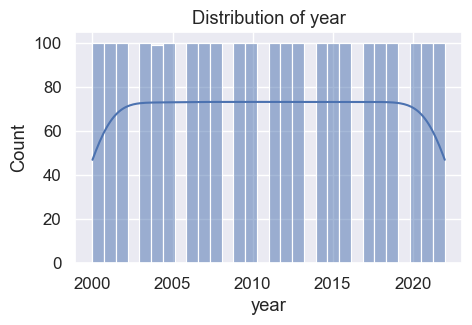

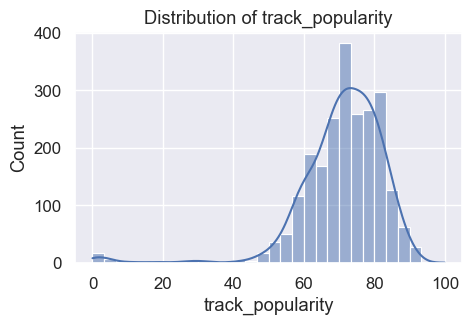

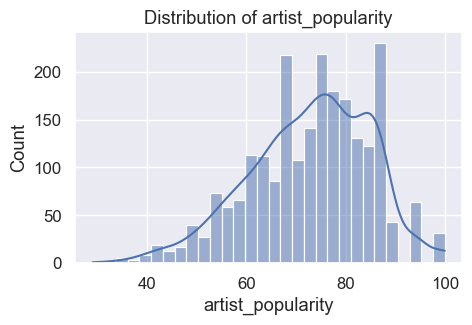

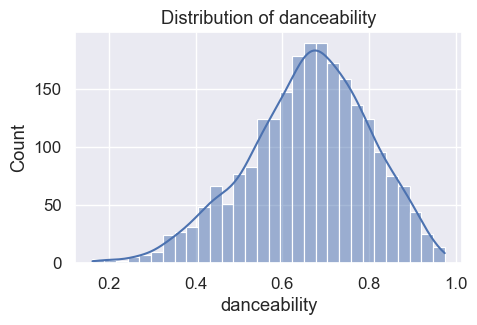

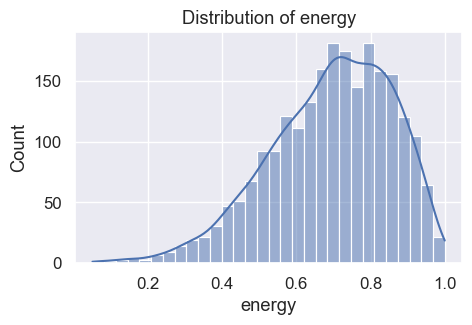

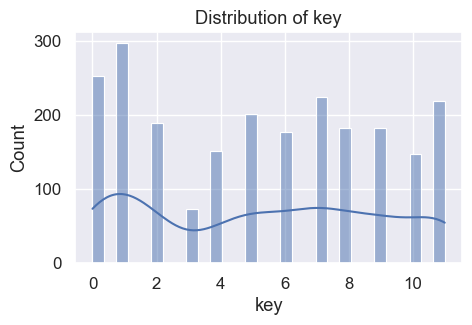

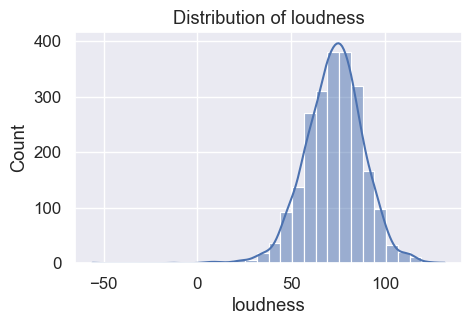

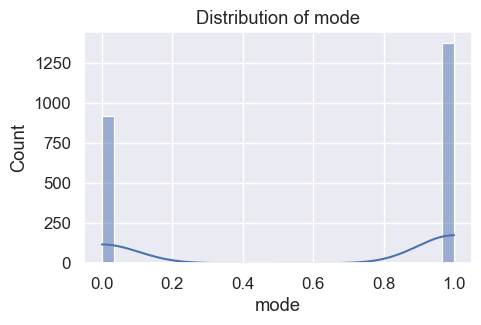

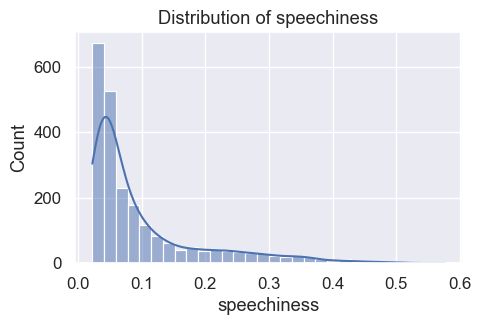

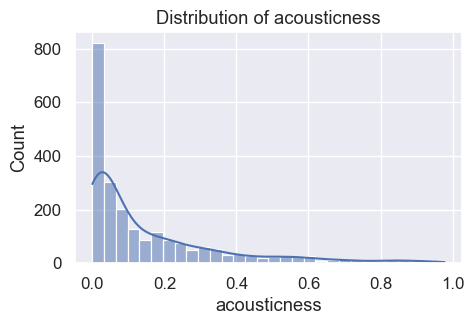

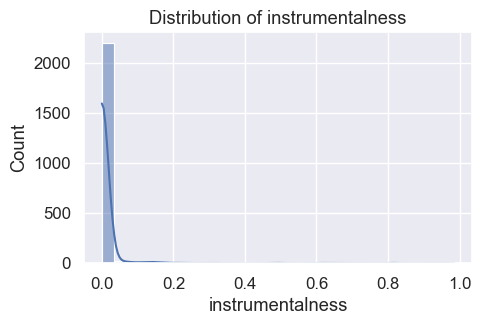

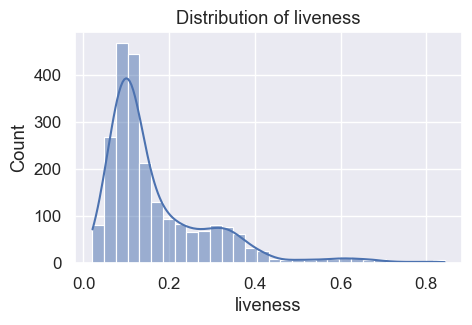

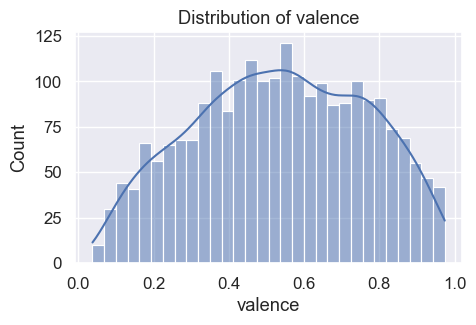

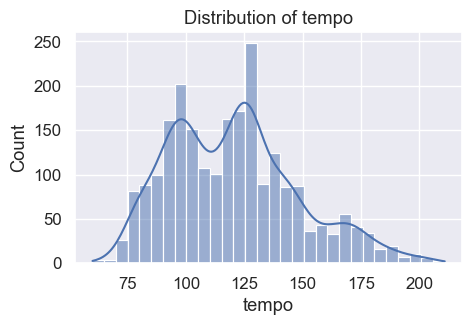

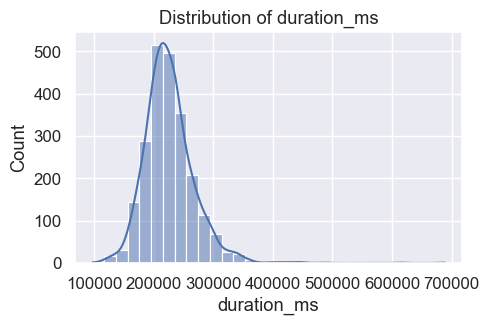

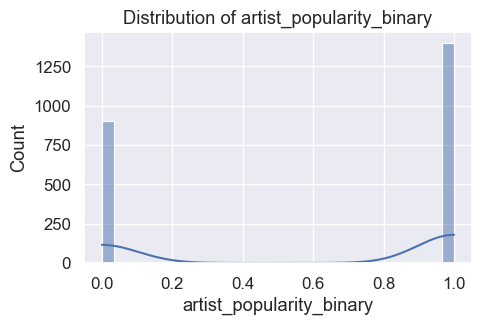

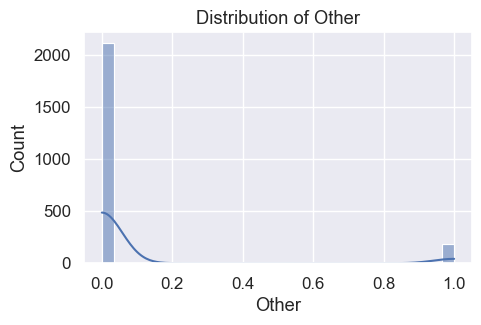

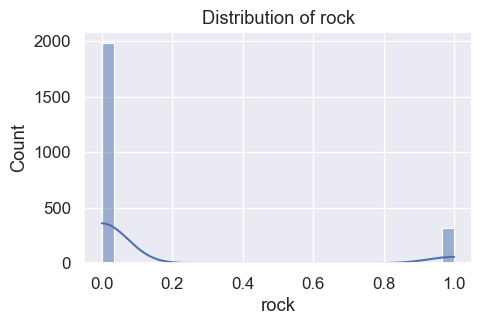

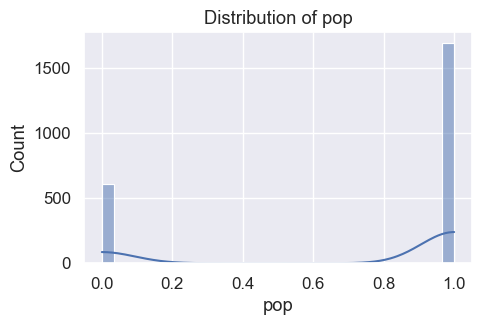

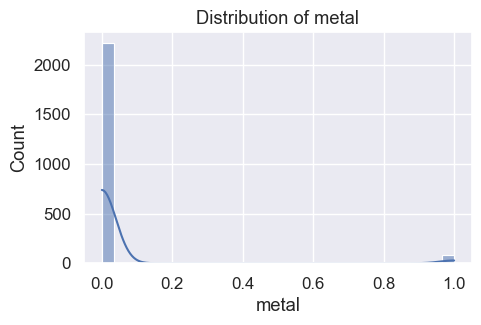

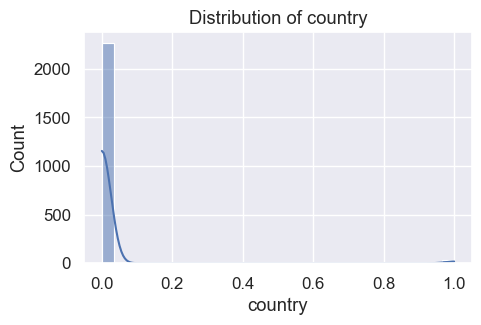

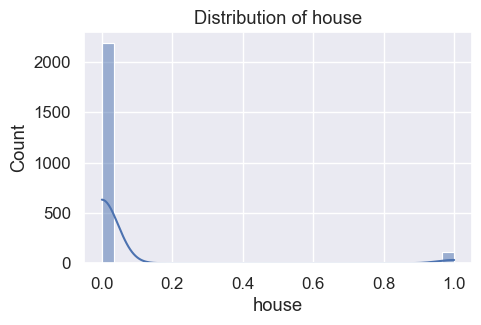

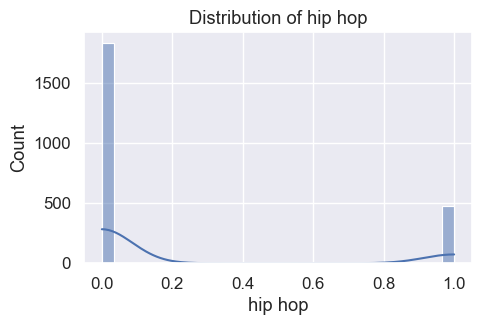

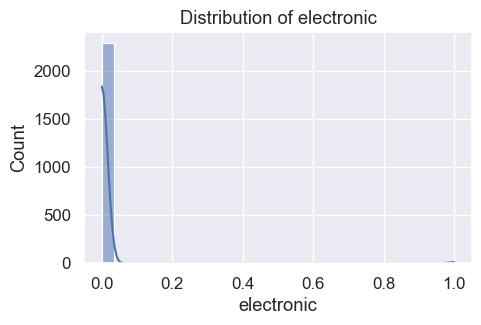

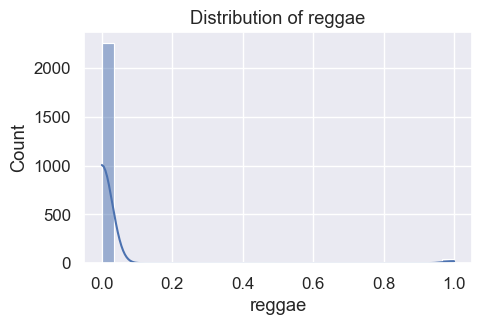

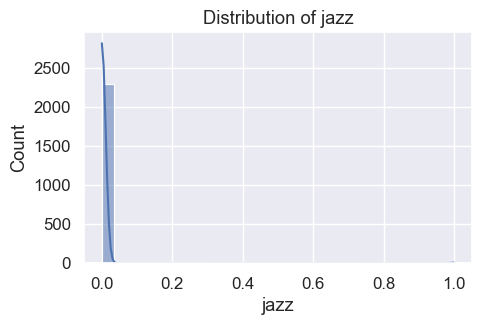

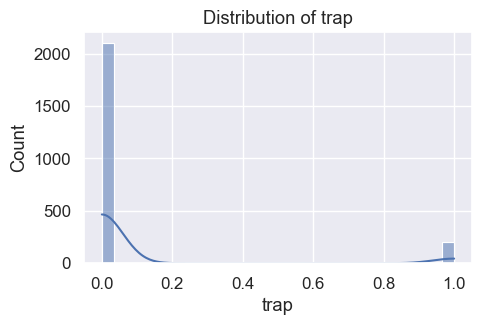

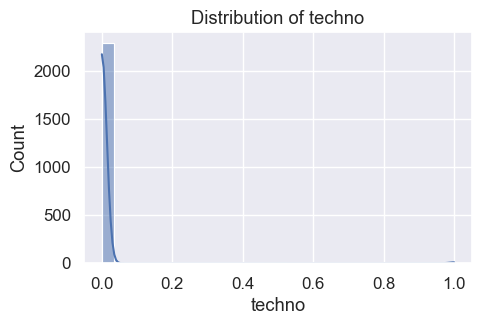

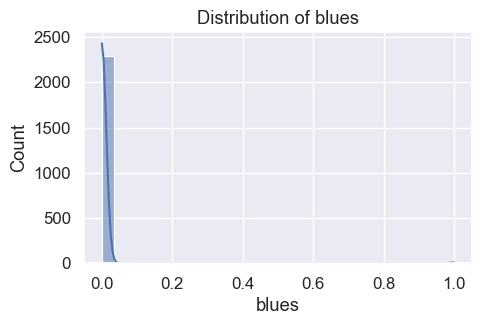

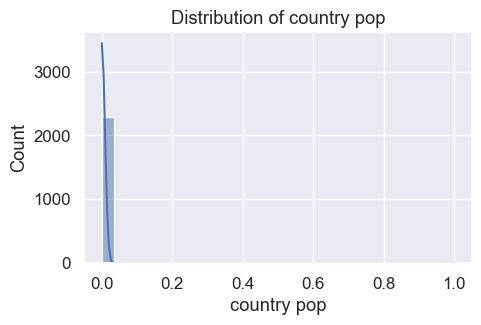

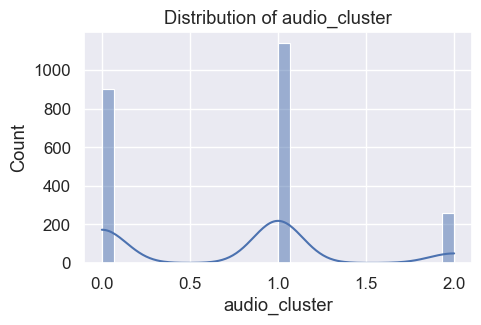

In [79]:
# Visualize distribution of each feature
for col in df.select_dtypes(include='number').columns:
    plt.figure(figsize=(5, 3))
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

---

#### Data Transformations

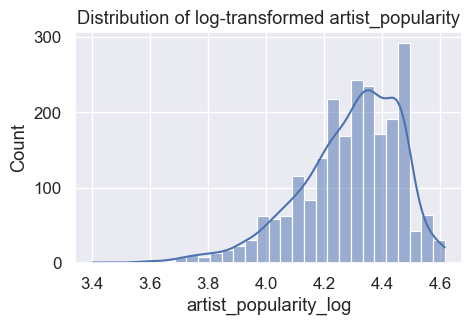

In [163]:
# Apply Log Transformation
df['artist_popularity_log'] = np.log1p(df['artist_popularity'])  # log1p handles log(0) safely

# Visualize the transformed distribution
plt.figure(figsize=(5, 3))
sns.histplot(df['artist_popularity_log'], bins=30, kde=True)
plt.title('Distribution of log-transformed artist_popularity')
plt.show()

[Text(0.5, 1.0, 'Histogram of track popularity variable')]

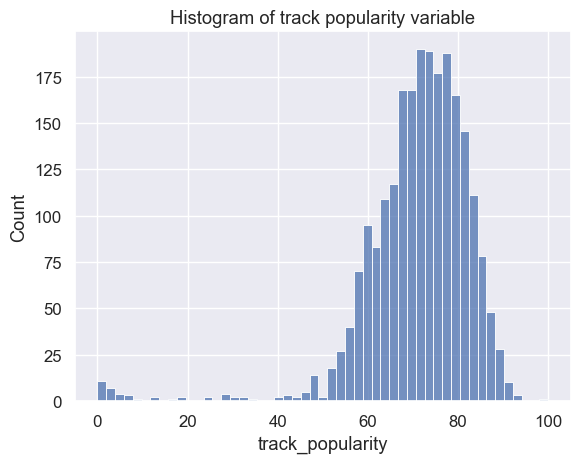

In [164]:
# Histogram of dependent variable
target = "track_popularity"
sns.histplot(df[target]).set(title='Histogram of track popularity variable')

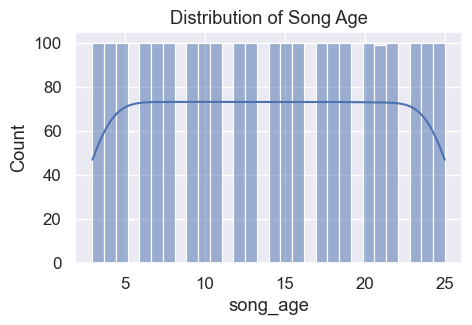

In [165]:
# Convert year to age
df['song_age'] = 2025 - df['year']  # Assuming current year is 2025

plt.figure(figsize=(5, 3))
sns.histplot(df['song_age'], bins=30, kde=True)
plt.title('Distribution of Song Age')
plt.show()

We can see that the track popularity data is skewed to the left. Thus, we have a skewed dependent variable and can run a model, but it is important to keep in mind that the residuals might be affected.

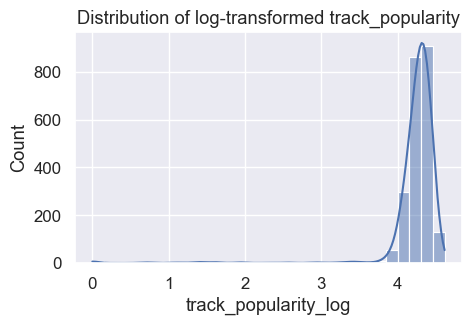

In [166]:
# Apply Log Transformation
df['track_popularity_log'] = np.log1p(df['track_popularity'])  # log1p handles log(0) safely

# Visualize the transformed distribution
plt.figure(figsize=(5, 3))
sns.histplot(df['track_popularity_log'], bins=30, kde=True)
plt.title('Distribution of log-transformed track_popularity')
plt.show()

In [83]:
df['track_popularity_log'].describe()

count    2299.00
mean        4.24
std         0.39
min         0.00
25%         4.20
50%         4.29
75%         4.38
max         4.62
Name: track_popularity_log, dtype: float64

Lower Bound: 3.9386915964665925, Upper Bound: 4.648027657598254
Original dataset size: 2299
Cleaned dataset size: 2229


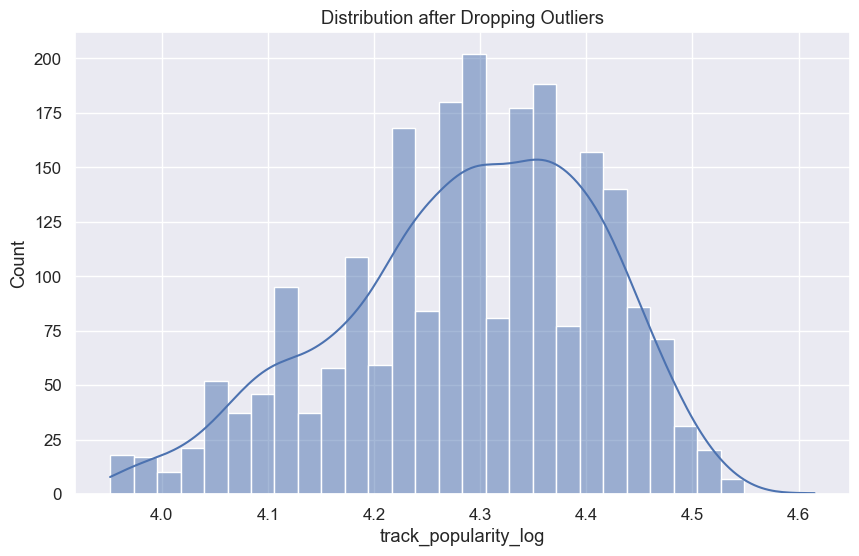

In [167]:
# Calculate the IQR
Q1 = df['track_popularity_log'].quantile(0.25)
Q3 = df['track_popularity_log'].quantile(0.75)
IQR = Q3 - Q1

# Determine the outlier thresholds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")

# Drop outliers
df_cleaned = df[(df['track_popularity_log'] >= lower_bound) & (df['track_popularity_log'] <= upper_bound)]

# Check the result
print(f"Original dataset size: {df.shape[0]}")
print(f"Cleaned dataset size: {df_cleaned.shape[0]}")


# Visualize the cleaned distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['track_popularity_log'], bins=30, kde=True)
plt.title('Distribution after Dropping Outliers')
plt.show()

In [168]:
# Get the column names
numerical_columns = list(df.select_dtypes(include=[np.number]).columns)
categorical_columns = list(df.select_dtypes(include=[object]).columns)
date_columns = list(df.select_dtypes(include=['<M8[ns]']).columns)

# Print a quick summary of what we just loaded
print("Loaded dataset")
print("   Rows: %s" % df.shape[0])
print("   Columns: %s (%s num, %s cat, %s date)" % (df.shape[1], 
                                                    len(numerical_columns), len(categorical_columns),
                                                    len(date_columns)))

Loaded dataset
   Rows: 2299
   Columns: 34 (34 num, 0 cat, 0 date)


---

### Correlation Analysis

In [169]:
df = df_cleaned.copy()

target = "track_popularity_log"

In [170]:
# Get the column names
numerical_columns = list(df.select_dtypes(include=[np.number]).columns)
categorical_columns = list(df.select_dtypes(include=[object]).columns)
date_columns = list(df.select_dtypes(include=['<M8[ns]']).columns)

# Print a quick summary of what we just loaded
print("Loaded dataset")
print("   Rows: %s" % df.shape[0])
print("   Columns: %s (%s num, %s cat, %s date)" % (df.shape[1], 
                                                    len(numerical_columns), len(categorical_columns),
                                                    len(date_columns)))

Loaded dataset
   Rows: 2229
   Columns: 34 (34 num, 0 cat, 0 date)


We will drop year, track_popularity, artist_popularity as they have been transformed 

In [171]:
#dropping the selected columns
columns_to_drop= ['year', 'track_popularity', 'artist_popularity']
print("Dropping the following columns: %s" % columns_to_drop)
df = df.drop(columns_to_drop, axis=1)

Dropping the following columns: ['year', 'track_popularity', 'artist_popularity']


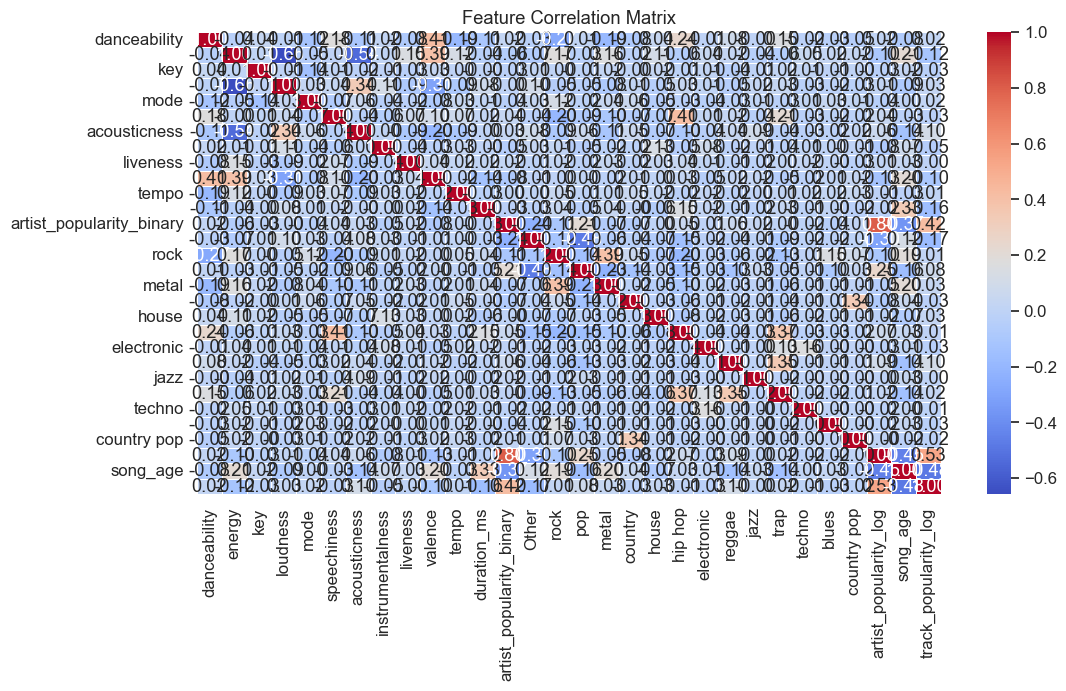

In [172]:
columns_to_plot = [
     'danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
       'artist_popularity_binary', 'Other', 'rock', 'pop', 'metal', 'country',
       'house', 'hip hop', 'electronic', 'reggae', 'jazz', 'trap', 'techno',
       'blues', 'country pop', 'artist_popularity_log',
       'song_age', 'track_popularity_log'
]

corr_matrix = df[columns_to_plot].corr()
plt.figure(figsize=(12, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show()

In [173]:
# Find highly correlated pairs
correlation_threshold = 0.5
high_corr_pairs = []

for col in corr_matrix.columns:
    for index in corr_matrix.index:
        if col != index and abs(corr_matrix.loc[col, index]) > correlation_threshold:
            high_corr_pairs.append((col, index))

# Print highly correlated features
print(f"Highly Correlated Features {correlation_threshold}:", high_corr_pairs)

Highly Correlated Features 0.5: [('energy', 'loudness'), ('energy', 'acousticness'), ('loudness', 'energy'), ('acousticness', 'energy'), ('artist_popularity_binary', 'artist_popularity_log'), ('artist_popularity_log', 'artist_popularity_binary'), ('artist_popularity_log', 'track_popularity_log'), ('track_popularity_log', 'artist_popularity_log')]


Now we need to drop all the correlated variables above 0.5:
- hip hop (keep) vs trap 
- valence (keep) vs danceability 
- pop (keep) vs Other
- acousticness (keep) vs energy 

In [174]:
# Find highly correlated pairs
correlation_threshold = 0.4
high_corr_pairs = []

for col in corr_matrix.columns:
    for index in corr_matrix.index:
        if col != index and abs(corr_matrix.loc[col, index]) > correlation_threshold:
            high_corr_pairs.append((col, index))

# Print highly correlated features
print(f"Highly Correlated Features {correlation_threshold}:", high_corr_pairs)

Highly Correlated Features 0.4: [('danceability', 'valence'), ('energy', 'loudness'), ('energy', 'acousticness'), ('loudness', 'energy'), ('speechiness', 'hip hop'), ('acousticness', 'energy'), ('valence', 'danceability'), ('artist_popularity_binary', 'artist_popularity_log'), ('artist_popularity_binary', 'track_popularity_log'), ('Other', 'pop'), ('pop', 'Other'), ('hip hop', 'speechiness'), ('artist_popularity_log', 'artist_popularity_binary'), ('artist_popularity_log', 'song_age'), ('artist_popularity_log', 'track_popularity_log'), ('song_age', 'artist_popularity_log'), ('song_age', 'track_popularity_log'), ('track_popularity_log', 'artist_popularity_binary'), ('track_popularity_log', 'artist_popularity_log'), ('track_popularity_log', 'song_age')]


In [175]:
#dropping the selected columns
columns_to_drop= [ 'trap', 'Other', 'danceability',
       'energy', 'artist_popularity_binary']
print("Dropping the following columns: %s" % columns_to_drop)
df = df.drop(columns_to_drop, axis=1)

Dropping the following columns: ['trap', 'Other', 'danceability', 'energy', 'artist_popularity_binary']


In [176]:
df_for_logit = df.copy() # Save copy for logistic regression

---

### Linear Regression Model

1. SKLEARN execution  
    A. Train/Test splitting  
    B. Stepwise execution  
    C. Plot selected variables   
    D. Create predictions  
    E. Model evaluation: charts and error measures in train and test datasets  
    F. Store predictions and errors in dataset  
    F. Use the model on the reserved dataset   
2. STATSMODEL

#### Rescaling Variables

In [177]:
ss = MinMaxScaler()

X_std = ss.fit_transform(df)

df = pd.DataFrame(X_std, columns=df.columns, index=df.index)

df

,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,rock,pop,metal,country,house,hip hop,electronic,reggae,jazz,techno,blues,country pop,audio_cluster,artist_popularity_log,song_age,track_popularity_log
0,0.36,0.76,0.0,0.05,2.35e-01,0.00e+00,0.09,0.91,0.15,0.23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.55,1.0,0.53
1,0.64,0.68,1.0,0.08,8.91e-04,0.00e+00,0.09,0.66,0.24,0.16,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.34,1.0,0.45
2,0.09,0.72,1.0,0.01,5.01e-01,0.00e+00,0.10,0.19,0.38,0.18,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.74,1.0,0.26
3,0.00,0.66,1.0,0.05,1.05e-02,0.00e+00,0.72,0.69,0.59,0.12,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.73,1.0,0.74
4,0.09,0.79,1.0,0.02,2.66e-01,0.00e+00,0.13,0.22,0.53,0.24,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.48,1.0,0.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2294,0.00,0.79,0.0,0.11,3.65e-01,0.00e+00,0.11,0.85,0.97,0.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.46,0.0,0.61
2295,0.45,0.70,1.0,0.03,2.53e-02,0.00e+00,0.68,0.58,0.58,0.13,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.80,0.0,0.63
2296,0.55,0.78,0.0,0.15,5.27e-01,4.17e-04,0.18,0.24,0.40,0.09,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.74,0.0,0.79
2297,0.45,0.63,0.0,0.11,9.08e-02,2.98e-03,0.12,0.90,0.32,0.13,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.86,0.0,0.79


---

#### Train & Test Split

We decided to reserve 10% of our data to implement predictions and simulate it is additional data as we did in class

In [178]:
df_model, df_reserved = train_test_split(df, test_size=0.1, random_state=42)
print ("Sample size dataset reserved for prediction: ", df_reserved.shape[0], "records")

y = df_model[target]

Sample size dataset reserved for prediction:  223 records


Train Test Split of 80% train and 20% test

In [179]:
# cross validation (80%-20%)
X_train, X_test, y_train, y_test = train_test_split(df_model, y, test_size=0.2)
print ("Sample size train dataset: ", X_train.shape)
print ("Sample size test dataset: ", X_test.shape)

Sample size train dataset:  (1604, 26)
Sample size test dataset:  (402, 26)


---

#### Stepwise Function

Function to define stepwise execution

In [180]:
# Stepwise function
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.05, 
                       threshold_out = 0.1, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(X[included+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.4}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(X[included])).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.4}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [181]:
# Removes some variables: target, irrelevent and those with missing values (stepwise does not work with them)
# we will call X_train2 to this dataframe

irrelevant_columns = [target]
X_train2=X_train.drop(columns=irrelevant_columns)

for field in X_train2:
    if X_train2[field].isnull().any():
        X_train2=X_train2.drop(labels=[field], axis=1)
        
X_train2

,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,rock,pop,metal,country,house,hip hop,electronic,reggae,jazz,techno,blues,country pop,audio_cluster,artist_popularity_log,song_age
1184,0.64,0.61,1.0,1.67e-01,1.93e-02,0.00e+00,0.16,0.65,0.55,0.24,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.58,0.50
597,0.00,0.82,0.0,9.58e-03,6.47e-01,1.79e-05,0.08,0.44,0.15,0.19,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.65,0.77
1785,0.55,0.69,1.0,5.29e-02,2.03e-01,0.00e+00,0.07,0.54,0.31,0.18,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.54,0.23
971,0.09,0.43,1.0,4.83e-01,2.87e-01,0.00e+00,0.29,0.43,0.18,0.29,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.81,0.59
1216,0.64,0.73,1.0,3.31e-02,1.16e-02,2.31e-06,0.11,0.66,0.40,0.16,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.69,0.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636,0.00,0.65,1.0,7.77e-03,2.36e-03,0.00e+00,0.19,0.29,0.18,0.25,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.58,0.73
641,0.45,0.61,1.0,9.14e-02,3.29e-03,0.00e+00,0.25,0.66,0.29,0.30,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.63,0.73
675,0.82,0.73,1.0,5.26e-02,2.74e-01,0.00e+00,0.06,0.42,0.13,0.19,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.63,0.73
1682,0.00,0.65,0.0,3.04e-02,9.48e-02,3.64e-05,0.25,0.46,0.41,0.17,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.68,0.27


In [182]:
result = stepwise_selection(X_train2, y_train)
print('resulting features:')
print(result)

Add  artist_popularity_log          with p-value 7.286e-116
Add  song_age                       with p-value 7.071e-41
Add  rock                           with p-value 2.262e-08
Add  metal                          with p-value 0.001752
Add  blues                          with p-value 0.02327
Add  pop                            with p-value 0.02459
Add  acousticness                   with p-value 0.02639
Add  valence                        with p-value 0.008596
Add  country pop                    with p-value 0.02598
resulting features:
['artist_popularity_log', 'song_age', 'rock', 'metal', 'blues', 'pop', 'acousticness', 'valence', 'country pop']


---

#### Pairplot & Heatmap

Create a Dataframe with chosen explanatory variables

In [126]:
X_train_stepwise=X_train2
for item in X_train2.columns:
    if item not in result:
        X_train_stepwise=X_train_stepwise.drop(labels=[item],axis=1) #removes the non relevant variables

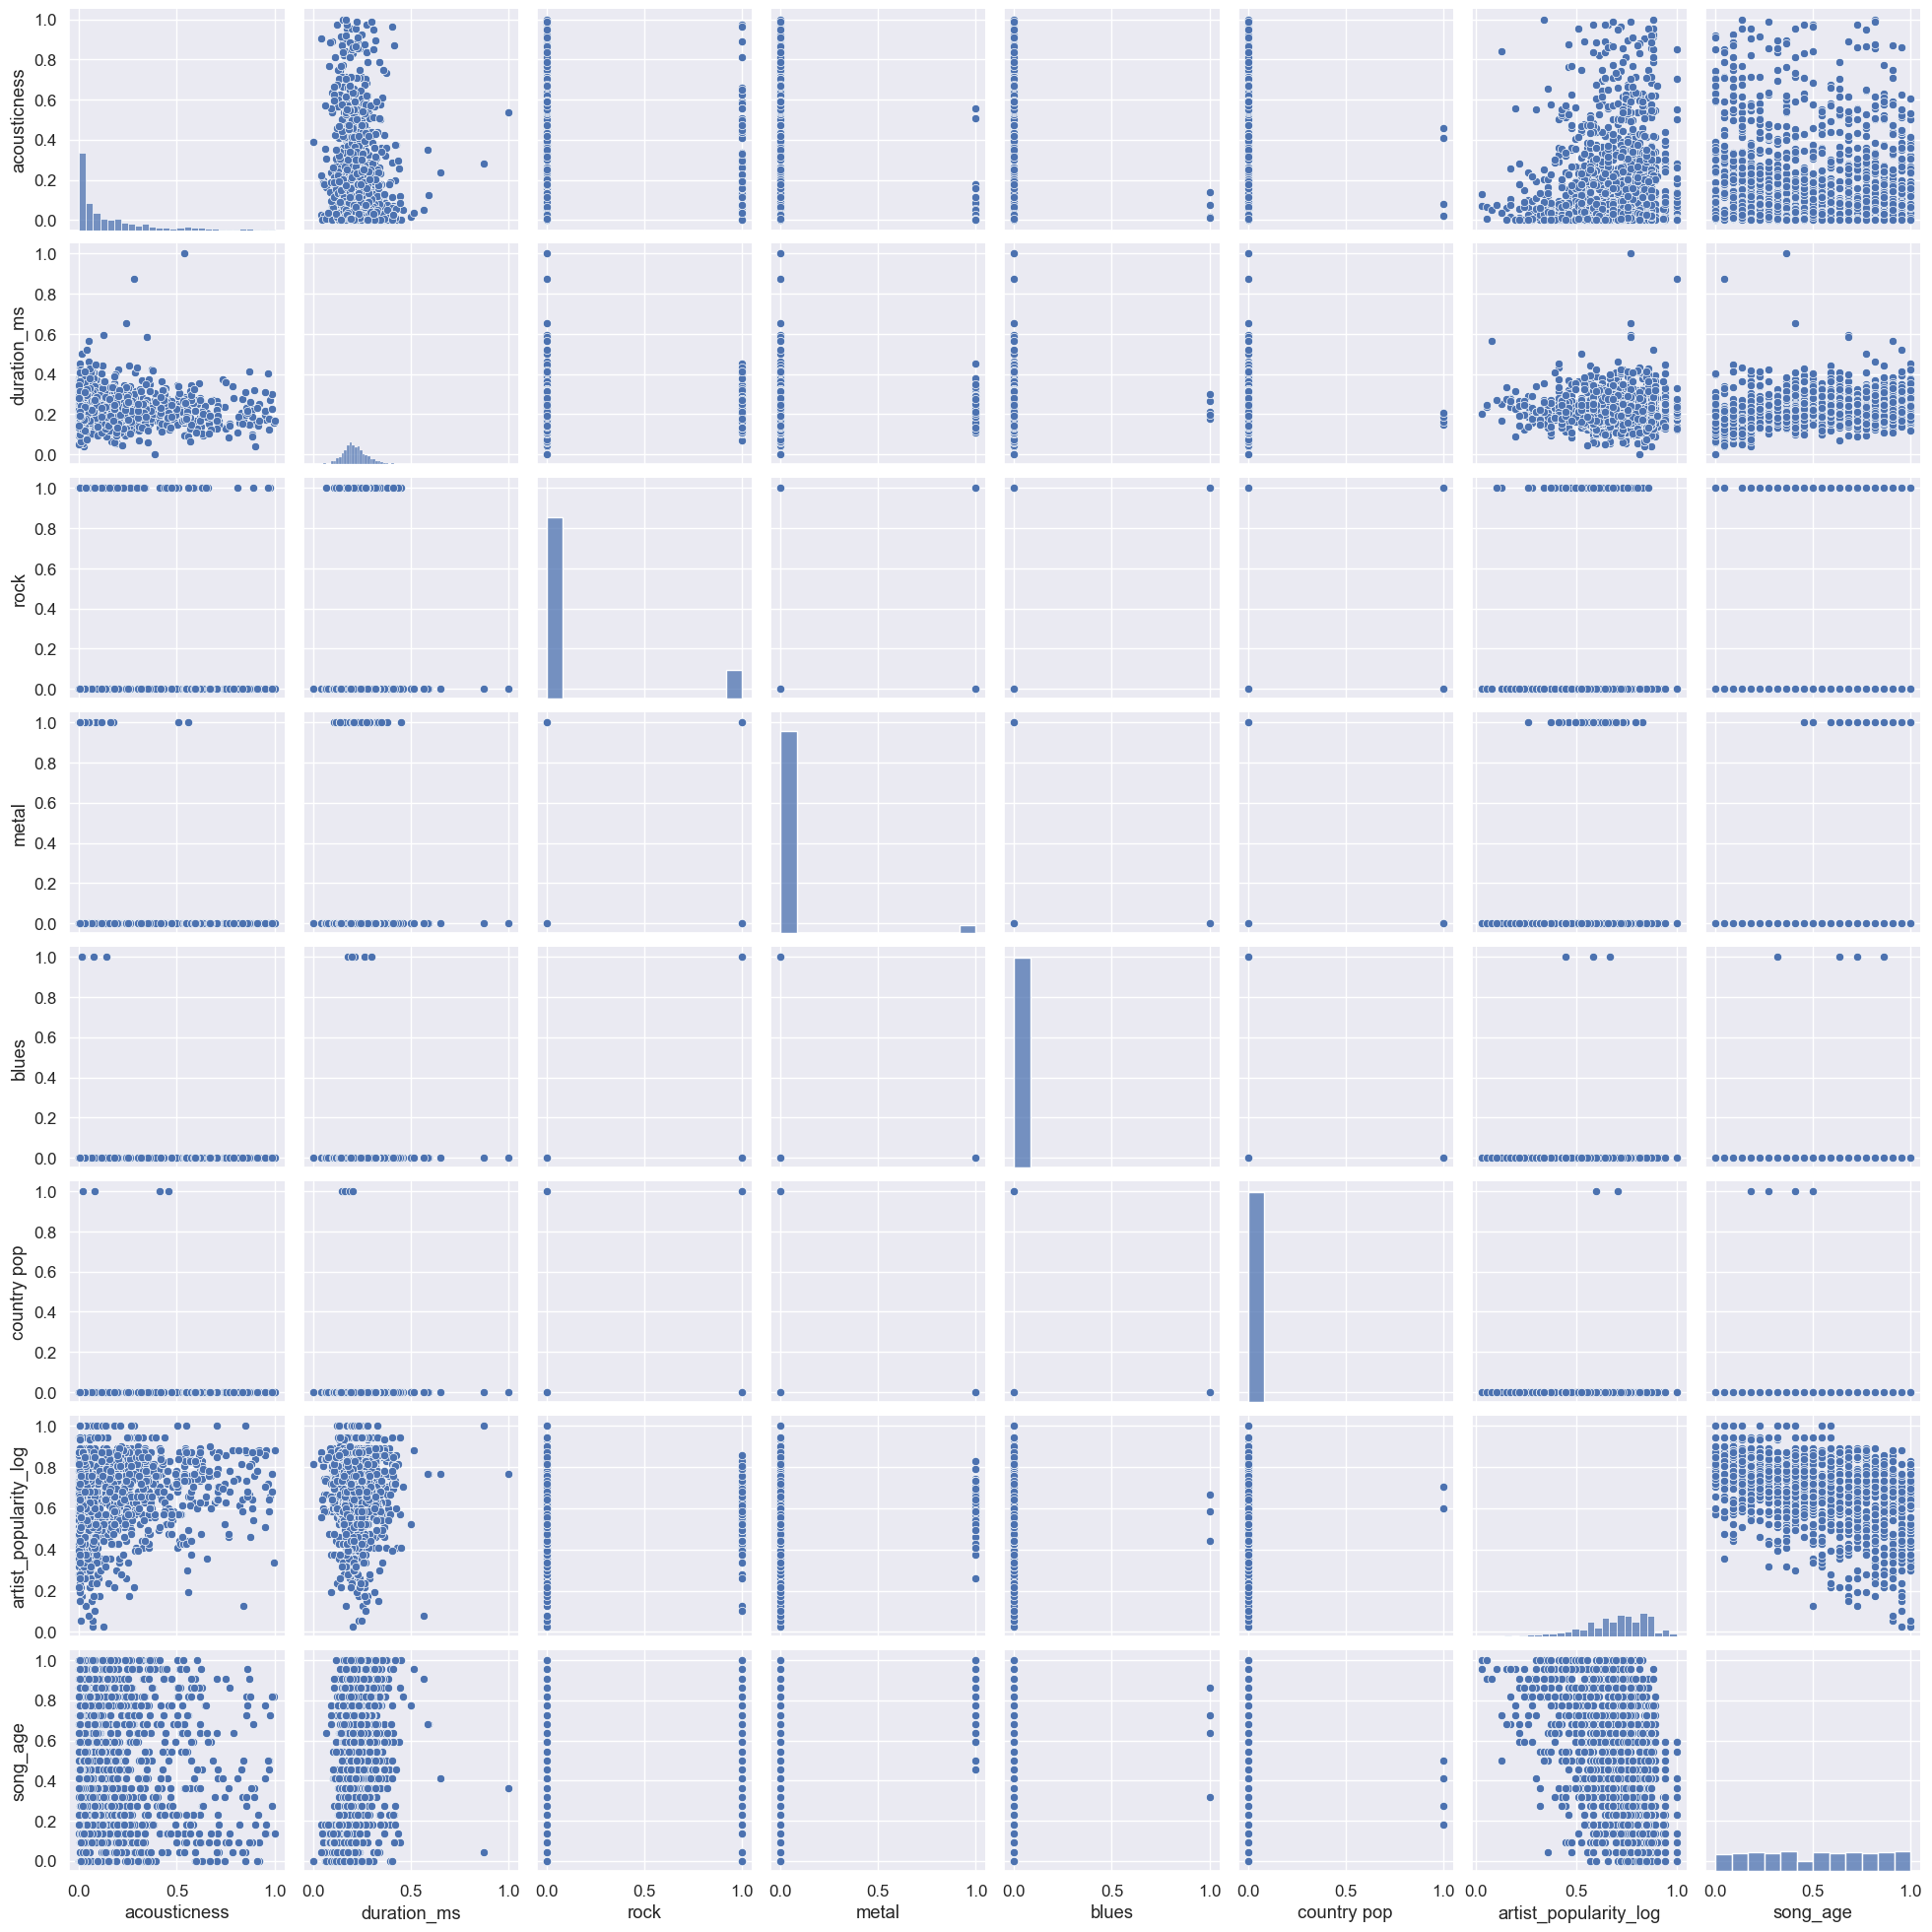

In [127]:
sns.pairplot(X_train_stepwise)

<Axes: >

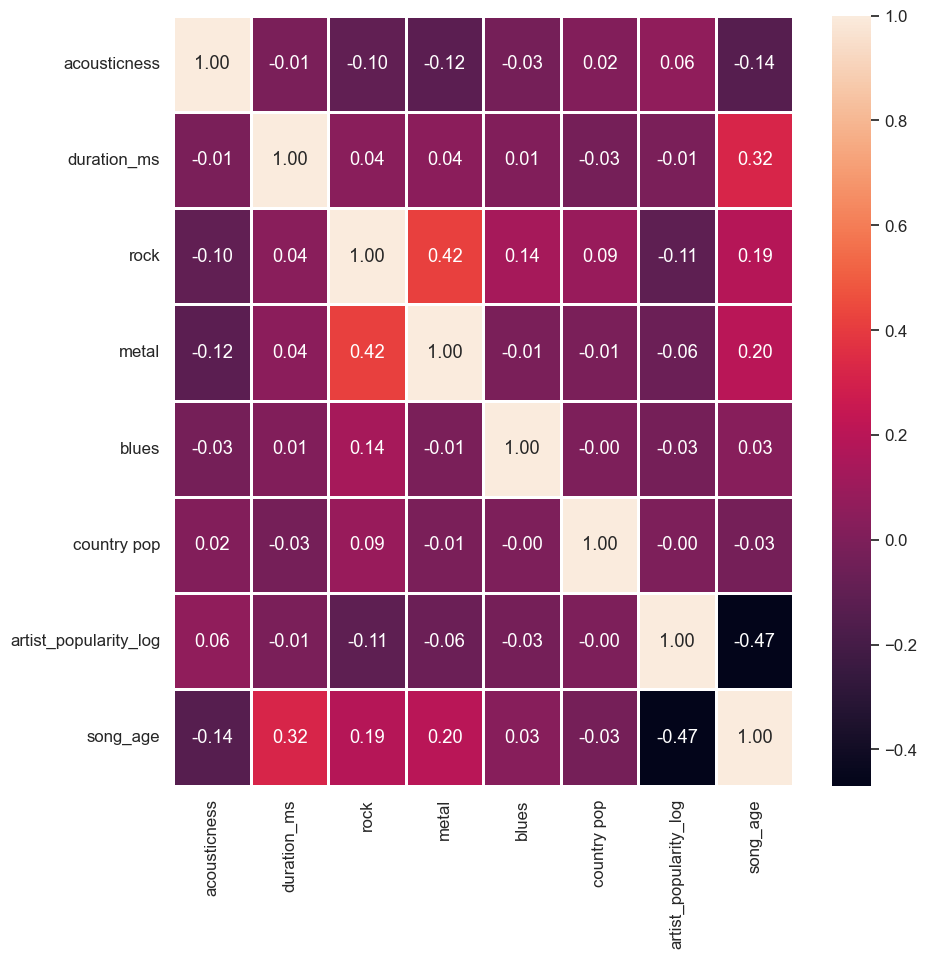

In [128]:
# and heatmap to show correlation between explanatory variables
sns.set(font_scale=1.1)
fig, ax = plt.subplots(figsize=(10,10))         
sns.heatmap(X_train_stepwise.corr(), annot=True, fmt=".2f", linewidths=1, ax=ax)

---

#### Model Training & Evaluation

In [129]:
lm = LinearRegression(fit_intercept=True)
model=lm.fit(X_train_stepwise, y_train)

Model Evaluation

In [130]:
# print R squared train dataset
print(f"R squared value is : {model.score(X_train_stepwise,y_train):.3f}")

R squared value is : 0.390


In [131]:
# print coefficients (but not confidence intervals: sklearn does not store them)
coeff_df = pd.DataFrame(model.coef_,X_train_stepwise.columns,columns=['Coefficient'])
print("Intercept: ", lm.intercept_)
coeff_df

Intercept:  0.3165211443294956


,Coefficient
acousticness,0.05
duration_ms,-0.15
rock,0.05
metal,0.08
blues,-0.18
country pop,-0.16
artist_popularity_log,0.44
song_age,-0.19


Create Predictions: If we accept the model, then we create predictions on both the train and the test dataset to compare them. First some charts comparing fitted and real values.

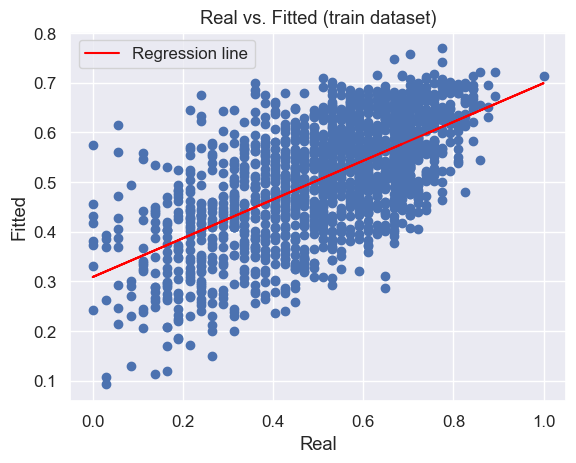

In [132]:
predictions_train = lm.predict(X_train[X_train_stepwise.columns]) #only with the columns used in the model

plt.title("Real vs. Fitted (train dataset)")
plt.scatter(y_train,predictions_train)

coef = np.polyfit(y_train, predictions_train, 1)  
poly1d_fn = np.poly1d(coef)  
plt.plot(y, poly1d_fn(y), color="red", label="Regression line")

plt.xlabel("Real")
plt.ylabel("Fitted")
plt.legend()
plt.show()

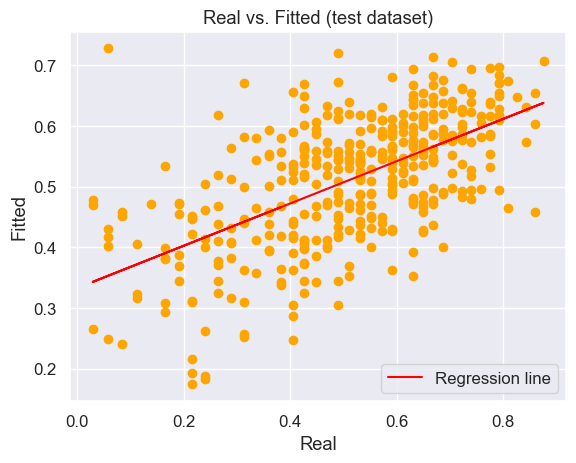

In [133]:
# test dataset
predictions_test = lm.predict(X_test[X_train_stepwise.columns]) #only with the columns used in the model
plt.title("Real vs. Fitted (test dataset)")
plt.scatter(y_test,predictions_test, color="orange")

coef = np.polyfit(y_test, predictions_test, 1)  
poly1d_fn = np.poly1d(coef)  
plt.plot(y_test, poly1d_fn(y_test), color="red", label="Regression line")

plt.xlabel("Real")
plt.ylabel("Fitted")

plt.legend()
plt.show()

Residual Histograms and residual histograms to check hypothesis of normality in residuals

[Text(0.5, 1.0, 'Histogram of dependent - train dataset')]

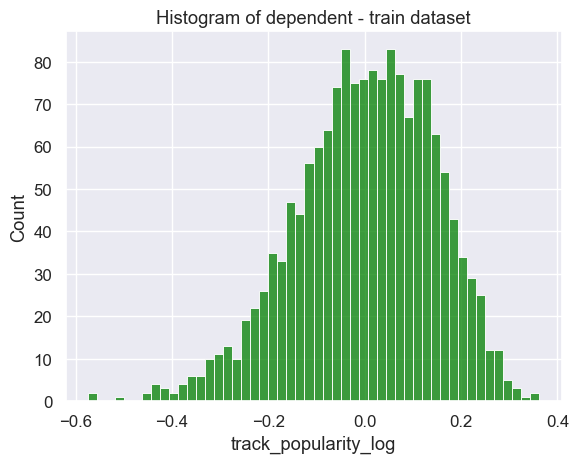

In [134]:
# training dataset
sns.histplot((y_train-predictions_train),bins=50, color="green").set(title='Histogram of dependent - train dataset')

[Text(0.5, 1.0, 'Histogram of dependent - test dataset')]

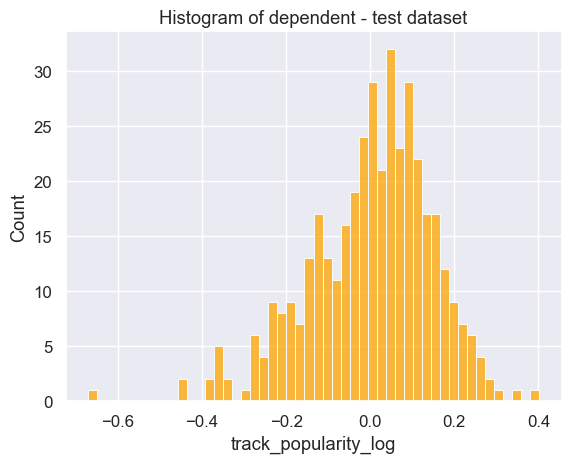

In [135]:
# test dataset
sns.histplot((y_test-predictions_test),bins=50, color="orange").set(title='Histogram of dependent - test dataset')

---

#### Regression Metrics

In [136]:
# error comparison between the two datasets
print ("Errors:\n")
results = {
    'Metric': ['MAE', 'MSE', 'RMSE', 'MAPE %'],
    'Train': [
        metrics.mean_absolute_error(y_train, predictions_train),
        metrics.mean_squared_error(y_train, predictions_train),
        np.sqrt(metrics.mean_squared_error(y_train, predictions_train)),
        np.mean(100 * abs(y_train - predictions_train) / y_train)
    ],
    'Test': [
        metrics.mean_absolute_error(y_test, predictions_test),
        metrics.mean_squared_error(y_test, predictions_test),
        np.sqrt(metrics.mean_squared_error(y_test, predictions_test)),
        np.mean(100 * abs(y_test - predictions_test) / y_test)
    ]
}

results_df = pd.DataFrame(results)
results_df

Errors:



,Metric,Train,Test
0,MAE,0.12,0.11
1,MSE,0.02,0.02
2,RMSE,0.14,0.15
3,MAPE %,inf,46.63


Store predictions and errors in the dataset

In [137]:
def store_predictions (df):
    df = df.copy()
    # first move target variable to the end to show it along with predictions and errors
    df = df[[col for col in df.columns if col !=target] + [target]]
    
    predictions = lm.predict(df[X_train_stepwise.columns])
    df.loc[:, target + "_predicted"] = predictions
    
    df.loc[:, "error"] = df[target] - df[target + "_predicted"]
    df.loc[:, "%abs error"] = abs(100*df["error"]) /  df[target]
    return df

In [138]:
X_train = store_predictions(X_train)
X_train

,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,rock,pop,metal,country,house,hip hop,electronic,reggae,jazz,techno,blues,country pop,audio_cluster,artist_popularity_log,song_age,track_popularity_log,track_popularity_log_predicted,error,%abs error
91,0.73,0.72,0.0,0.11,4.11e-02,5.82e-05,0.03,0.89,0.29,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.43,1.00,0.43,0.28,1.50e-01,35.25
800,0.55,0.79,0.0,0.46,3.96e-02,2.05e-03,0.21,0.79,0.61,0.21,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.84,0.64,0.53,0.53,-4.10e-04,0.08
504,0.27,0.62,1.0,0.02,4.58e-01,3.41e-03,0.16,0.52,0.53,0.23,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.48,0.77,0.61,0.41,2.00e-01,32.80
836,0.64,0.61,1.0,0.03,6.17e-05,0.00e+00,0.06,0.88,0.48,0.21,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.81,0.64,0.53,0.52,1.09e-02,2.05
95,0.00,0.64,1.0,0.14,6.18e-02,0.00e+00,0.15,0.80,0.46,0.17,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.32,1.00,0.43,0.24,1.86e-01,43.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
827,0.55,0.57,0.0,0.02,2.56e-04,9.16e-05,0.06,0.84,0.89,0.14,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.22,0.64,0.29,0.27,2.18e-02,7.55
210,0.73,0.74,1.0,0.01,2.52e-01,0.00e+00,0.20,0.32,0.49,0.26,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.34,0.91,0.03,0.26,-2.33e-01,812.61
1463,0.91,0.66,1.0,0.03,6.24e-04,1.15e-06,0.12,0.55,0.43,0.28,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.81,0.36,0.45,0.56,-1.15e-01,25.61
377,0.73,0.74,1.0,0.14,1.80e-01,0.00e+00,0.28,0.59,0.15,0.25,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.52,0.86,0.36,0.35,7.29e-03,2.03


In [139]:
X_test = store_predictions(X_test)
X_test

,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,rock,pop,metal,country,house,hip hop,electronic,reggae,jazz,techno,blues,country pop,audio_cluster,artist_popularity_log,song_age,track_popularity_log,track_popularity_log_predicted,error,%abs error
164,0.36,0.72,0.0,0.56,2.81e-03,0.00e+00,0.04,0.78,0.95,0.16,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.58,0.95,0.38,0.36,1.68e-02,4.40
649,0.09,0.71,1.0,0.71,1.63e-02,0.00e+00,0.08,0.61,0.46,0.26,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.39,0.73,0.31,0.31,3.13e-03,1.00
1970,0.00,0.69,1.0,0.19,1.78e-01,0.00e+00,0.39,0.11,0.94,0.16,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.67,0.14,0.59,0.57,2.37e-02,4.02
963,0.09,0.51,0.0,0.03,6.45e-02,7.24e-05,0.07,0.77,0.57,0.20,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.87,0.59,0.55,0.56,-6.02e-03,1.09
1020,0.64,0.65,0.0,0.04,1.83e-01,0.00e+00,0.81,0.63,0.46,0.20,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.64,0.55,0.63,0.47,1.58e-01,25.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280,1.00,0.59,1.0,0.25,3.09e-02,9.11e-06,0.39,0.56,0.78,0.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.37,0.91,0.40,0.25,1.58e-01,39.05
1546,0.00,0.76,1.0,0.04,4.09e-01,0.00e+00,0.19,0.41,0.32,0.22,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.73,0.32,0.65,0.56,8.56e-02,13.19
405,0.36,0.68,0.0,0.01,1.10e-01,0.00e+00,0.09,0.58,0.27,0.17,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.83,0.82,0.43,0.63,-2.04e-01,47.89
876,0.82,0.70,1.0,0.06,1.74e-03,1.06e-02,0.14,0.36,0.62,0.18,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.69,0.64,0.74,0.52,2.22e-01,29.97


Finally we apply our model to the reserved dataset and calculate metrics

In [140]:
df_reserved = store_predictions(df_reserved)
df_reserved

,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,rock,pop,metal,country,house,hip hop,electronic,reggae,jazz,techno,blues,country pop,audio_cluster,artist_popularity_log,song_age,track_popularity_log,track_popularity_log_predicted,error,%abs error
56,0.00,0.80,1.0,1.39e-02,1.02e-01,1.26e-04,0.38,0.88,0.39,0.23,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.51,1.00,0.26,0.32,-5.21e-02,19.68
502,0.18,0.57,1.0,3.29e-02,2.85e-01,7.04e-01,0.05,0.80,0.52,0.12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.46,0.77,0.51,0.36,1.46e-01,28.57
1699,0.18,0.73,1.0,2.05e-01,5.39e-02,0.00e+00,0.21,0.41,0.66,0.19,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,1.00,0.23,0.76,0.69,7.15e-02,9.44
219,0.00,0.68,0.0,1.22e-01,6.34e-02,3.30e-03,0.08,0.48,0.42,0.30,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.78,0.91,0.11,0.44,-3.30e-01,295.45
968,0.82,0.84,1.0,8.00e-02,2.58e-01,2.10e-06,0.08,0.17,0.37,0.36,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.46,0.59,0.31,0.36,-4.99e-02,15.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,0.82,0.64,1.0,8.85e-03,2.03e-01,6.57e-05,0.14,0.11,0.29,0.29,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.61,0.73,0.72,0.46,2.64e-01,36.56
1205,0.91,0.73,1.0,5.69e-02,1.75e-03,0.00e+00,0.27,0.32,0.53,0.38,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.63,0.45,0.36,0.49,-1.35e-01,37.54
234,0.18,0.73,0.0,1.16e-02,2.46e-01,3.80e-06,0.13,0.70,0.20,0.28,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.65,0.91,0.36,0.40,-3.92e-02,10.91
1091,0.55,0.63,0.0,3.45e-02,7.27e-04,1.47e-05,0.07,0.79,0.52,0.16,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.63,0.55,0.59,0.51,8.20e-02,13.86


In [141]:
# calculates error, %error and MAPE into the dataframe
print ("Errors in reserved dataset:\n")

print(f"MAE:, {abs(df_reserved["error"]).mean():.2f}")

#print(f"R squared value is : {model.score(X_train_stepwise,y_train):.3f}")
MSE = np.square(df_reserved["error"]).mean()

print(f"MSE: {MSE:.2f}") 
print(f"RMSE: {np.sqrt(MSE):.2f}") 
print (f"MAPE %: {df_reserved["%abs error"].mean():.2f}") 

Errors in reserved dataset:

MAE:, 0.12
MSE: 0.02
RMSE: 0.15
MAPE %: 38.87


---

#### Additional Info (STATSMODELS LIBRARY)

In [142]:
# model with an additional library (statmodels)
X_train_stepwise = sm.add_constant(X_train_stepwise) 

result = sm.OLS(y_train, X_train_stepwise).fit()
print (result.summary())

                             OLS Regression Results                             
Dep. Variable:     track_popularity_log   R-squared:                       0.390
Model:                              OLS   Adj. R-squared:                  0.387
Method:                   Least Squares   F-statistic:                     127.6
Date:                  Sun, 23 Feb 2025   Prob (F-statistic):          2.09e-165
Time:                          10:03:17   Log-Likelihood:                 832.59
No. Observations:                  1604   AIC:                            -1647.
Df Residuals:                      1595   BIC:                            -1599.
Df Model:                             8                                         
Covariance Type:              nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const     

---

### Logistic Regression

#### Import Cleaned Dataset

In [143]:
df = df_for_logit

---

#### Rescaling Variables

In [144]:
ss = StandardScaler()

X_std = ss.fit_transform(df)

df = pd.DataFrame(X_std, columns=df.columns, index=df.index)

df

,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,rock,pop,metal,country,house,hip hop,electronic,reggae,jazz,techno,blues,country pop,audio_cluster,artist_popularity_log,song_age,track_popularity_log
0,-0.35,0.89,-1.22,-0.53,0.36,-0.16,-5.83e-01,1.55,-1.35,0.20,-0.40,-1.67,-0.20,-0.13,-0.23,-0.51,-0.08,-0.15,-0.05,-0.07,-0.06,-0.04,-1.11,-0.83,1.65,0.13
1,0.48,-0.13,0.82,-0.34,-0.77,-0.16,-5.92e-01,0.55,-0.86,-0.88,2.48,0.60,-0.20,-0.13,-0.23,-0.51,-0.08,-0.15,-0.05,-0.07,-0.06,-0.04,-1.11,-2.15,1.65,-0.33
2,-1.17,0.44,0.82,-0.73,1.64,-0.16,-5.38e-01,-1.39,-0.09,-0.59,-0.40,0.60,-0.20,-0.13,-0.23,-0.51,-0.08,-0.15,-0.05,-0.07,-0.06,-0.04,0.42,0.32,1.65,-1.32
3,-1.45,-0.26,0.82,-0.53,-0.73,-0.16,3.34e+00,0.65,1.03,-1.41,2.48,0.60,5.08,-0.13,-0.23,-0.51,-0.08,-0.15,-0.05,-0.07,-0.06,-0.04,0.42,0.24,1.65,1.27
4,-1.17,1.22,0.82,-0.70,0.51,-0.16,-3.63e-01,-1.28,0.70,0.34,-0.40,-1.67,-0.20,7.92,-0.23,-0.51,-0.08,-0.15,-0.05,-0.07,-0.06,-0.04,-1.11,-1.30,1.65,0.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2294,-1.45,1.28,-1.22,-0.16,0.98,-0.16,-4.62e-01,1.29,3.10,-0.25,-0.40,-1.67,-0.20,-0.13,-0.23,-0.51,-0.08,-0.15,-0.05,-0.07,-0.06,-0.04,-1.11,-1.40,-1.69,0.56
2295,-0.07,0.19,0.82,-0.65,-0.65,-0.16,3.12e+00,0.18,0.97,-1.29,-0.40,0.60,-0.20,-0.13,-0.23,-0.51,-0.08,-0.15,-0.05,-0.07,-0.06,-0.04,0.42,0.68,-1.69,0.67
2296,0.21,1.09,-1.22,0.06,1.76,-0.16,1.40e-03,-1.20,0.02,-1.86,-0.40,0.60,-0.20,-0.13,4.37,-0.51,-0.08,-0.15,-0.05,-0.07,-0.06,-0.04,0.42,0.32,-1.69,1.55
2297,-0.07,-0.71,-1.22,-0.13,-0.34,-0.13,-4.16e-01,1.52,-0.45,-1.28,-0.40,0.60,-0.20,-0.13,-0.23,-0.51,-0.08,-0.15,-0.05,-0.07,-0.06,-0.04,0.42,1.02,-1.69,1.55


In [145]:
df['is_track_popular']= df['track_popularity_log'].apply(lambda x: 1 if x > 0.65 else 0)
df

,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,rock,pop,metal,country,house,hip hop,electronic,reggae,jazz,techno,blues,country pop,audio_cluster,artist_popularity_log,song_age,track_popularity_log,is_track_popular
0,-0.35,0.89,-1.22,-0.53,0.36,-0.16,-5.83e-01,1.55,-1.35,0.20,-0.40,-1.67,-0.20,-0.13,-0.23,-0.51,-0.08,-0.15,-0.05,-0.07,-0.06,-0.04,-1.11,-0.83,1.65,0.13,0
1,0.48,-0.13,0.82,-0.34,-0.77,-0.16,-5.92e-01,0.55,-0.86,-0.88,2.48,0.60,-0.20,-0.13,-0.23,-0.51,-0.08,-0.15,-0.05,-0.07,-0.06,-0.04,-1.11,-2.15,1.65,-0.33,0
2,-1.17,0.44,0.82,-0.73,1.64,-0.16,-5.38e-01,-1.39,-0.09,-0.59,-0.40,0.60,-0.20,-0.13,-0.23,-0.51,-0.08,-0.15,-0.05,-0.07,-0.06,-0.04,0.42,0.32,1.65,-1.32,0
3,-1.45,-0.26,0.82,-0.53,-0.73,-0.16,3.34e+00,0.65,1.03,-1.41,2.48,0.60,5.08,-0.13,-0.23,-0.51,-0.08,-0.15,-0.05,-0.07,-0.06,-0.04,0.42,0.24,1.65,1.27,1
4,-1.17,1.22,0.82,-0.70,0.51,-0.16,-3.63e-01,-1.28,0.70,0.34,-0.40,-1.67,-0.20,7.92,-0.23,-0.51,-0.08,-0.15,-0.05,-0.07,-0.06,-0.04,-1.11,-1.30,1.65,0.02,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2294,-1.45,1.28,-1.22,-0.16,0.98,-0.16,-4.62e-01,1.29,3.10,-0.25,-0.40,-1.67,-0.20,-0.13,-0.23,-0.51,-0.08,-0.15,-0.05,-0.07,-0.06,-0.04,-1.11,-1.40,-1.69,0.56,0
2295,-0.07,0.19,0.82,-0.65,-0.65,-0.16,3.12e+00,0.18,0.97,-1.29,-0.40,0.60,-0.20,-0.13,-0.23,-0.51,-0.08,-0.15,-0.05,-0.07,-0.06,-0.04,0.42,0.68,-1.69,0.67,1
2296,0.21,1.09,-1.22,0.06,1.76,-0.16,1.40e-03,-1.20,0.02,-1.86,-0.40,0.60,-0.20,-0.13,4.37,-0.51,-0.08,-0.15,-0.05,-0.07,-0.06,-0.04,0.42,0.32,-1.69,1.55,1
2297,-0.07,-0.71,-1.22,-0.13,-0.34,-0.13,-4.16e-01,1.52,-0.45,-1.28,-0.40,0.60,-0.20,-0.13,-0.23,-0.51,-0.08,-0.15,-0.05,-0.07,-0.06,-0.04,0.42,1.02,-1.69,1.55,1


---

#### Train & Test Split

We decided to reserve 10% of our data to implement predictions and simulate it is additional data as we did in class

In [146]:
target = "is_track_popular"

df_model, df_reserved = train_test_split(df, test_size=0.1, random_state=42)
print ("Sample size dataset reserved for prediction: ", df_reserved.shape[0], "records")

# Sets y
y = df_model[target]

Sample size dataset reserved for prediction:  223 records


In [147]:
# cross validation (80%-20%)
X_train, X_test, y_train, y_test = train_test_split(df_model, y, test_size=0.2)
print ("Sample size train dataset: ", X_train.shape)
print ("Sample size test dataset: ", X_test.shape)

Sample size train dataset:  (1604, 27)
Sample size test dataset:  (402, 27)


---

#### Stepwise Function

In [148]:
# Stepwise function
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.05, #95 % confidence threshold
                       threshold_out = 0.1, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.Logit(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.Logit(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [149]:
# Removes some variables: target, irrelevent and those with missing values (stepwise does not work with them)
# we will call X_train2 to this dataframe

irrelevant_columns = ['track_popularity_log',target]#need to remove the Y variable - because it cannot be explanatory
X_train2=X_train.drop(columns=irrelevant_columns)

for field in X_train2:
    if X_train2[field].isnull().any():
        X_train2=X_train2.drop(labels=[field], axis=1)
        
X_train2

,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,rock,pop,metal,country,house,hip hop,electronic,reggae,jazz,techno,blues,country pop,audio_cluster,artist_popularity_log,song_age
1934,-0.07,-1.93e+00,0.82,-0.39,0.18,-0.16,-0.82,0.64,-1.39,-0.85,-0.40,0.60,-0.2,-0.13,-0.23,-0.51,-0.08,-0.15,-0.05,-0.07,-0.06,-0.04,0.42,0.24,-1.24
399,-0.07,3.81e-01,0.82,-0.80,-0.68,0.41,-0.29,0.67,-0.95,0.55,-0.40,-1.67,-0.2,-0.13,-0.23,-0.51,-0.08,-0.15,-0.05,-0.07,-0.06,-0.04,0.42,0.24,1.20
2240,0.48,-6.91e-02,-1.22,-0.66,2.10,-0.16,0.35,1.38,0.17,-1.52,-0.40,0.60,-0.2,-0.13,-0.23,-0.51,-0.08,6.89,-0.05,-0.07,-0.06,-0.04,0.42,0.75,-1.69
1414,-1.45,-7.76e-01,-1.22,-0.18,-0.64,-0.10,1.30,-0.82,0.28,-0.32,-0.40,0.60,-0.2,-0.13,4.37,-0.51,-0.08,-0.15,-0.05,-0.07,-0.06,-0.04,0.42,0.88,-0.48
1575,0.76,8.94e-01,-1.22,1.38,0.56,-0.16,1.12,-0.26,-0.74,-0.08,-0.40,0.60,-0.2,-0.13,4.37,-0.51,-0.08,-0.15,-0.05,-0.07,-0.06,-0.04,1.96,0.39,-0.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
963,-1.17,-2.12e+00,-1.22,-0.65,-0.47,-0.16,-0.68,0.99,0.93,-0.26,-0.40,0.60,-0.2,-0.13,-0.23,-0.51,-0.08,-0.15,-0.05,-0.07,-0.06,-0.04,0.42,1.08,0.28
1690,-1.45,3.81e-01,0.82,-0.36,0.10,-0.16,-0.42,-1.47,-0.12,-0.78,2.48,0.60,-0.2,-0.13,-0.23,-0.51,-0.08,-0.15,-0.05,-0.07,-0.06,-0.04,-1.11,-0.23,-0.78
2267,-0.90,-4.87e-03,-1.22,-0.60,-0.71,-0.16,-0.42,0.51,1.44,-0.47,-0.40,0.60,-0.2,-0.13,-0.23,-0.51,-0.08,-0.15,-0.05,-0.07,-0.06,-0.04,0.42,0.24,-1.69
1728,0.76,-6.91e-02,0.82,-0.64,-0.76,-0.16,1.00,0.42,-0.56,-0.88,-0.40,0.60,-0.2,-0.13,-0.23,-0.51,-0.08,-0.15,-0.05,-0.07,-0.06,-0.04,0.42,1.08,-0.93


In [150]:
#we execute the stepwise function - iterative process to identify relevant variables -- until it converges 
result = stepwise_selection(X_train2, y_train)
print('resulting features:')
print(result) # relevant variables
type(result)

         Current function value: 0.614248
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.614832
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614528
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614921
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.530080
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.613337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614388
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613833
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.610583
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608976
         Iterations 5
Optimization ter

c:\Users\SABIO\Documents\GitHub\IE-University\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\SABIO\Documents\GitHub\IE-University\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\SABIO\Documents\GitHub\IE-University\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\SABIO\Documents\GitHub\IE-University\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

Optimization terminated successfully.
         Current function value: 0.512593
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.510592
         Iterations 6
         Current function value: 0.511918
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.512278
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.509837
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.511482
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.512483
         Iterations 6
Add  rock                           with p-value 1.11704e-06
Optimization terminated successfully.
         Current function value: 0.505418
         Iterations 6
         Current function value: 0.504007
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.505041
         Iter

c:\Users\SABIO\Documents\GitHub\IE-University\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\SABIO\Documents\GitHub\IE-University\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\SABIO\Documents\GitHub\IE-University\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\SABIO\Documents\GitHub\IE-University\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

Optimization terminated successfully.
         Current function value: 0.499492
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.499613
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.499783
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.499445
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.497909
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.499805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.499784
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.499836
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.499749
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.499852
  

c:\Users\SABIO\Documents\GitHub\IE-University\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\SABIO\Documents\GitHub\IE-University\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\SABIO\Documents\GitHub\IE-University\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


list

We estimate the model only with selected features from Stepwise and we select them in the test dataset as well

In [151]:
# Adds selected features
X_train_stepwise=X_train2
for item in X_train2.columns:
    if item not in result:
        X_train_stepwise=X_train_stepwise.drop(labels=[item],axis=1) #removes the non relevant variables

X_train_stepwise

,speechiness,acousticness,rock,pop,country,artist_popularity_log,song_age
1934,-0.39,0.18,-0.40,0.60,-0.13,0.24,-1.24
399,-0.80,-0.68,-0.40,-1.67,-0.13,0.24,1.20
2240,-0.66,2.10,-0.40,0.60,-0.13,0.75,-1.69
1414,-0.18,-0.64,-0.40,0.60,-0.13,0.88,-0.48
1575,1.38,0.56,-0.40,0.60,-0.13,0.39,-0.63
...,...,...,...,...,...,...,...
963,-0.65,-0.47,-0.40,0.60,-0.13,1.08,0.28
1690,-0.36,0.10,2.48,0.60,-0.13,-0.23,-0.78
2267,-0.60,-0.71,-0.40,0.60,-0.13,0.24,-1.69
1728,-0.64,-0.76,-0.40,0.60,-0.13,1.08,-0.93


In [152]:
X_test_stepwise = X_test

for item in X_test.columns:
    if item not in result:
        X_test_stepwise=X_test_stepwise.drop(labels=[item],axis=1) #removes the non relevant variables

X_test_stepwise

,speechiness,acousticness,rock,pop,country,artist_popularity_log,song_age
1481,1.44,-0.61,-0.4,0.60,-0.13,0.39,-0.48
722,-0.51,-0.52,-0.4,0.60,-0.13,0.24,0.59
1524,-0.59,1.16,-0.4,0.60,-0.13,0.39,-0.63
2239,0.83,-0.78,-0.4,0.60,-0.13,1.52,-1.69
267,-0.72,-0.59,-0.4,-1.67,-0.13,0.24,1.35
...,...,...,...,...,...,...,...
1370,-0.30,-0.68,-0.4,0.60,-0.13,-0.07,-0.32
1523,0.34,-0.51,-0.4,0.60,-0.13,-1.02,-0.63
1747,3.52,0.85,-0.4,0.60,-0.13,0.75,-0.93
1715,0.51,-0.62,-0.4,-1.67,-0.13,-1.40,-0.93


---

#### Heatmap

<Axes: >

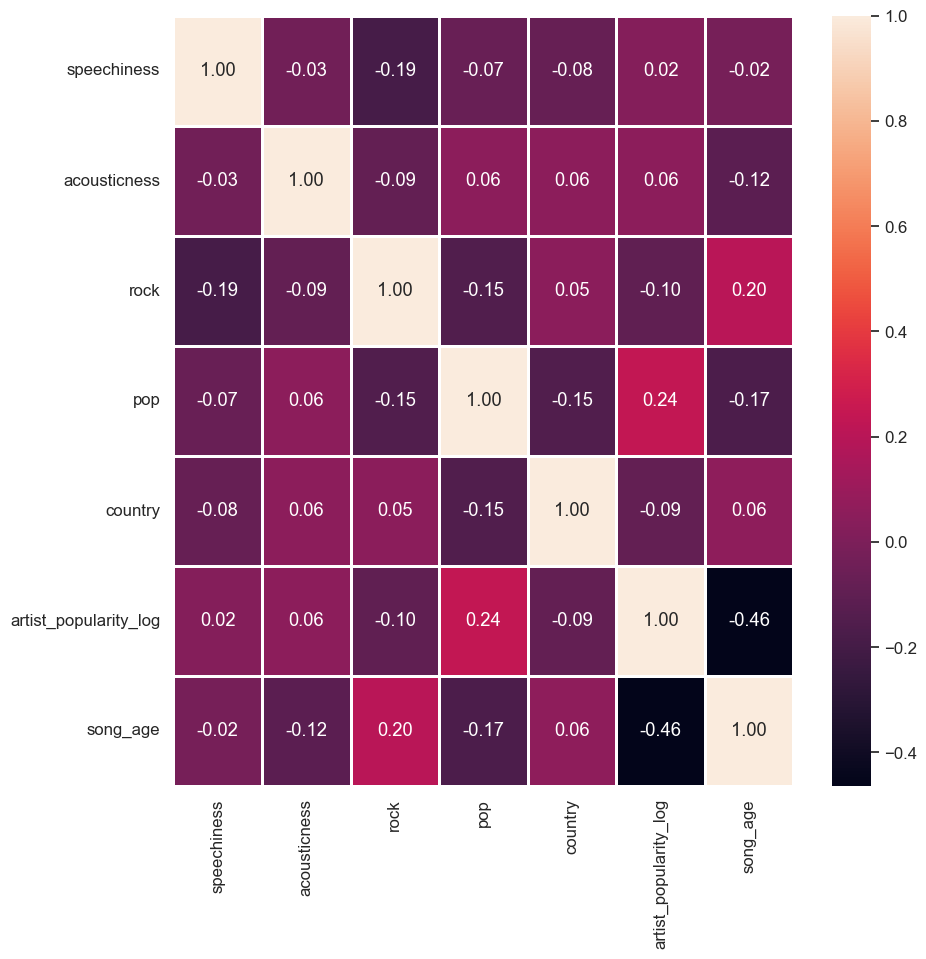

In [153]:
# and heatmap to show correlation between explanatory variables
from matplotlib import pyplot as plt        
import seaborn as sns                       

sns.set(font_scale=1.1)
fig, ax = plt.subplots(figsize=(10,10))         
sns.heatmap(X_train_stepwise.corr(), annot=True, fmt=".2f", linewidths=1, ax=ax)

---

#### STATSMODELS LIBRARY

In [155]:
X_train_stepwise = sm.add_constant(X_train_stepwise)

logit_model=sm.Logit(y_train,X_train_stepwise)
result=logit_model.fit_regularized()
print(result.summary2())

# print Exp(B) and confidence intervals
params = result.params
conf = result.conf_int()
conf['OR'] = params
conf.columns = ['Lower', 'Upper', 'Odds Ratio']
print ("\nexp(B) & confidence intervals: ")
print (np.exp(conf))

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.4954135350385434
            Iterations: 29
            Function evaluations: 29
            Gradient evaluations: 29
                            Results: Logit
Model:                 Logit             Method:            MLE       
Dependent Variable:    is_track_popular  Pseudo R-squared:  0.194     
Date:                  2025-02-23 10:05  AIC:               1605.2866 
No. Observations:      1604              BIC:               1648.3287 
Df Model:              7                 Log-Likelihood:    -794.64   
Df Residuals:          1596              LL-Null:           -986.35   
Converged:             1.0000            LLR p-value:       8.6213e-79
No. Iterations:        29.0000           Scale:             1.0000    
----------------------------------------------------------------------
                       Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-------------------------------------

---

#### Confusion Matrix

In [156]:
cutoff = 0.3 # Every probability above 30% is considered a positive to maximize the AUC of train set

train_preds = result.predict(X_train_stepwise)
train_preds_binary = (train_preds > cutoff).astype(int)  # Convert to binary labels (0 o 1)
train_conf_matrix = confusion_matrix(y_train, train_preds_binary)

train_conf_matrix_percentage = train_conf_matrix.astype('float') / train_conf_matrix.sum() * 100
train_conf_matrix_percentage = np.round(train_conf_matrix_percentage, 2)

print("Train dataset confusion matrix")
print(train_conf_matrix_percentage)

Train dataset confusion matrix
[[45.95 23.57]
 [ 7.54 22.94]]


In [157]:
#comparing now to the test dataset - confusion matrix should be similar to the train dataset
X_test_stepwise = sm.add_constant(X_test_stepwise)

test_preds = result.predict(X_test_stepwise)
test_preds_binary = (test_preds > cutoff).astype(int)  

test_conf_matrix = confusion_matrix(y_test, test_preds_binary)
test_conf_matrix_percentage = test_conf_matrix.astype('float') / test_conf_matrix.sum() * 100
test_conf_matrix_percentage = np.round(test_conf_matrix_percentage, 2)

print("Test dataset confusion matrix")
print(test_conf_matrix_percentage)

Test dataset confusion matrix
[[49.25 18.41]
 [10.7  21.64]]


Since the classification table looks similar between the train and test sets, there does not seem to be overfitting. Thus, I can use the model to predict 

---

#### Calculate AUC, ROC and Optimal threshold for Accuracy

In [158]:
#defines the function to draw the curve with three parameters
def ROCCurve (df, target, txtdataset): #df is the data set, targ is 
    result = sm.Logit(target, df).fit()
    df['pred'] = result.predict(df)

    # AUC
    result = sm.Logit(target, df).fit()
    X_train_stepwise['pred'] = result.predict(df)
    fpr, tpr, thresholds =roc_curve(target, df['pred'])
    roc_auc = auc(fpr, tpr)
    print("Area under the ROC curve : %f" % roc_auc)
    
    # Draws the roc curve
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots() 
    title='ROC curve for ' + txtdataset + " dataset"
    ax.set_title(title)
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.plot(fpr, tpr) #False Positive Rate(x axis) vs. True Positive Rate (y axis)
    ax.plot([0, 1], [0, 1], color="green")
    
    # Optimal cut-off
    i = np.arange(len(tpr)) # index for df
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'cut-off' : pd.Series(thresholds, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]
    print("Optimal cut-off for accuracy : " , list(roc_t['cut-off'])) #tells you how to achieve the highest accuracy in the curve
    print(tpr, fpr, thresholds)

Optimization terminated successfully.
         Current function value: 0.495414
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.494244
         Iterations 8
Area under the ROC curve : 0.784750
Optimal cut-off for accuracy :  [0.3525646413326987]
[0.         0.00204499 0.01840491 0.01840491 0.02249489 0.02249489
 0.03476483 0.03476483 0.03885481 0.03885481 0.04907975 0.04907975
 0.05725971 0.05725971 0.0593047  0.0593047  0.07157464 0.07157464
 0.10429448 0.10429448 0.11042945 0.11042945 0.11247444 0.11247444
 0.11860941 0.11860941 0.12883436 0.12883436 0.14110429 0.14110429
 0.14519427 0.14519427 0.15337423 0.15337423 0.1595092  0.1595092
 0.16155419 0.16155419 0.16359918 0.16359918 0.16768916 0.16768916
 0.17177914 0.17177914 0.17382413 0.17382413 0.17586912 0.17586912
 0.1799591  0.1799591  0.18404908 0.18404908 0.18609407 0.18609407
 0.19222904 0.19222904 0.19427403 0.19427403 0.20654397 0.20654397
 0.21063395 0.21063395 0.21676892 0.21

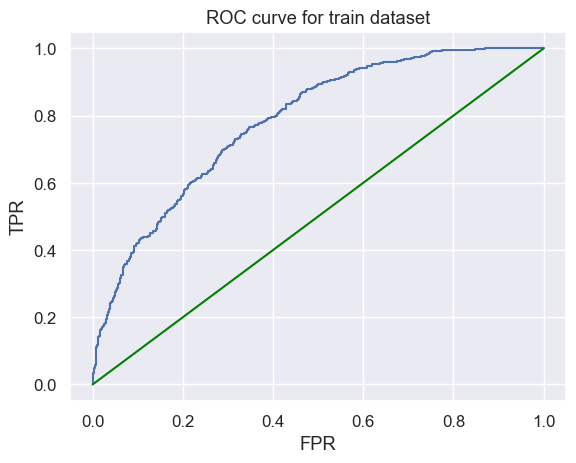

In [159]:
ROCCurve (X_train_stepwise, y_train, "train")

         Current function value: inf
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.512216
         Iterations 29
Area under the ROC curve : 0.741855
Optimal cut-off for accuracy :  [0.35696475411364104]
[0.         0.         0.01538462 0.01538462 0.03076923 0.03076923
 0.03846154 0.03846154 0.09230769 0.09230769 0.10769231 0.10769231
 0.13076923 0.13076923 0.13846154 0.13846154 0.14615385 0.14615385
 0.19230769 0.19230769 0.20769231 0.20769231 0.24615385 0.24615385
 0.26153846 0.26153846 0.26923077 0.26923077 0.28461538 0.28461538
 0.29230769 0.29230769 0.3        0.3        0.33076923 0.33076923
 0.33846154 0.33846154 0.38461538 0.38461538 0.4        0.4
 0.41538462 0.41538462 0.43846154 0.43846154 0.44615385 0.44615385
 0.45384615 0.45384615 0.47692308 0.47692308 0.48461538 0.48461538
 0.5        0.5        0.50769231 0.50769231 0.52307692 0.52307692
 0.53076923 0.53076923 0.53846154 0.53846154 0.56923077 0.56923077
 0.59230769 0.59

c:\Users\SABIO\Documents\GitHub\IE-University\.venv\Lib\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
c:\Users\SABIO\Documents\GitHub\IE-University\.venv\Lib\site-packages\statsmodels\discrete\discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))
c:\Users\SABIO\Documents\GitHub\IE-University\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


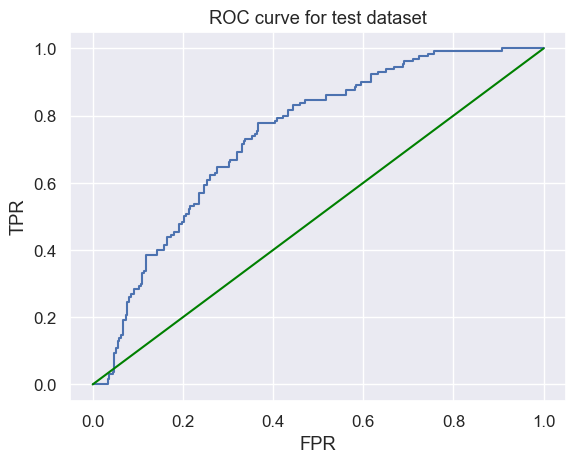

In [160]:
ROCCurve (X_test_stepwise, y_test, "test")

Area under the curve is similar in train and test. 
The ROC curve can be used to determine the optimal cutoff 

---